# Abstract  
**1. 분석 주제**  
- 모두의 주차장 유저별 이용횟수 예측하기 (머신러닝 모델링)  
  
**2. 분석 자료**  
- 2020년 모두의 주차장 유저 Dataset  
- 2020년 일별 기상 데이터(공공API), 대기오염 데이터 (서울, 수도권) 
- 2020년 일별 교통량 데이터 (서울)  
    
**3. 분석 가설**   
- 시간, 장소, 환경 요인과 앱 서비스 유형, 유저의 이동 패턴 정보로 유저의 주차장 수요를 예측할 수 있을 것이다. 
> :: 시간 : 요일, 공휴일 여부, 유저별 이용일 기준 가입 기간   
> :: 장소 : 주차장(추정) 구역  
> :: 환경 : 대기오염(미세먼지 농도), 일일 교통량(서울권)  
> :: 유저 이동 패턴 : 방문한 주차장(추정) 갯수, 방문한 구역(추정) 갯수,  Goods type

**4. 분석 단계(방법)**   
- EDA 및 추가 feature 생성 
- 상관관계 확인 후 Feature Selection  
- Cross validation Strategy, Modeling Strategy 세우기  
- 최종 모델 선택, 하이퍼 파라미터 튜닝 -> Modeling  
  
**5. 모델링 결과**  
- LGBM MSE/MAE : 0.038/0.039
- RF MSE/MAE :  0.043/0.069

# Intro   
  
  
1. 주차장 공유 경제 현황 및 전망 
- 코로나로 인해 개인간 접촉을 꺼려하는 사회적 분위기가 조성됨  
- 대중교통 보다는 개인 자동차를 이용하는 사람들이 많아지면서 주차장에 대한 수요가 증가하고 있음.  
- 따라서 주차장 공유 경제에 대한 전망은 밝다고 사료됨  
  
2. 유저의 공유 주차장 수요 예측의 필요성   
  
    1) 공유 주차장에 대한 정부 지원 활성화와 정부 지원 기회 확보  
>- 도심 지역 주차난을 해소하기 위해 정부의 공유 주차장 지원이 이전보다 활발해짐 
>- 따라서 수요 예측을 통해 정부 지원 기회를 확보할 수 있음  
  
    2) 자본 및 투자유치   
>- 수요 예측을 통해 주차 공급량과 실시간 수요에 보다 효과적이고 유연한 시스템을 구축할 수 있음. 
>- 이렇게 구축된 시스템은 서비스에 대한 신뢰로 이어질 것이고 추후 투자 기회를 확보하는데 발판이 될 것이라 사료됨 
  
    
3. 평가 
- 현재 “모두의 주차장”은 다운로드 수 1위, 주차장 수 1위를 지키며 상승세에 있음.  
- 플랫폼 사업의 특성상 영업이익보다 중요한 것은 매출액임.  
- 현 유저들의 수요 예측 모델링은 효율적이고 유연하고 신뢰성 있는 시스템을 구축하는 발판이 될 것이며 더 큰 매출 성장과 지속적인 투자를 가져다 줄 것이라 기대됨.   
  
---------

# Data Load 

## Library Import

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns 
%matplotlib inline 
from matplotlib import rc
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use(['ggplot'])


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
import platform
import missingno as msno
from datetime import datetime, timezone, timedelta
import pytz
from tqdm.notebook import tqdm as tqdm

import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.options.display.float_format = '{:.0f}'.format
pd.options.display.max_rows=1000
        
# seed 설정
np.random.seed(42)


# API 크롤링 라이브러리 
from urllib.parse import urlencode, quote_plus
from urllib.request import Request, urlopen
from xml.etree import ElementTree 
from urllib.error import HTTPError, URLError
import requests

#model 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Dataset  
### 기본 Dataset : 모두 컴퍼니 유저 Dataset 

In [2]:
data = pd.read_csv('실전db1.csv')

### 외부 Dataset   
#### 일별 교통량 

In [3]:
trans = pd.read_csv('교통량통합.csv')
#DATE 값 일치시켜주기
trans['DATE'] = pd.to_datetime(trans['DATE']).apply(lambda x:x.strftime('%Y-%m-%d'))

#### 미세먼지   
- 서울권 미세먼지 : http://data.seoul.go.kr/dataList/OA-2218/S/1/datasetView.do  
- 공공 API 미세먼지 경보 발령

In [4]:
#서울권 미세먼지 
dust_big = pd.read_csv('일평균대기오염도_2020.csv')

In [5]:
# API 크롤링 
# url = 'http://apis.data.go.kr/B552584/UlfptcaAlarmInqireSvc/getUlfptcaAlarmInfo'

# params = '?'+ 'ServiceKey=' + service_key + '&' + \
#     urlencode({ quote_plus('ServiceKey') : '서비스키', 
#                 quote_plus('numOfRows') : '500', 
#                quote_plus('returnType') : 'xml',
#                quote_plus('year') : '2020' })


               
# df = pd.DataFrame()
    
       
# request = Request(url + params)
# request.get_method = lambda: 'GET'

# try:
#     response_body = urlopen(request).read()
# except HTTPError as e:
#     print(e)
# except URLError as e:
#     print('The server coult not be found')
# else:
#     print('성공')

# root= ElementTree.fromstring(response_body)

# for item in root.iter('item'):
#     item_dict = {}
#     item_dict['발령일'] = item.find('dataDate').text
#     item_dict['지역명'] = item.find('districtName').text
#     item_dict['권역명'] = item.find('moveName').text
#     item_dict['항목명'] = item.find('itemCode').text
#     item_dict['경보단계'] = item.find('issueGbn').text
#     item_dict['발령일'] = item.find('issueDate').text
#     item_dict['발령시간'] = item.find('issueTime').text
#     item_dict['발령농도'] = item.find('issueVal').text

    
#     df=df.append(item_dict, ignore_index=True)
# #     print(df)

# # df.to_csv(path_or_buf =r'dust.csv', encoding='euc-kr')

# print(df)

# # dust = pd.read_csv('dust.csv', encoding='CP949')
# dust =dust.sort_values('발령일')
# df.to_csv(path_or_buf =r'dust.csv', encoding='euc-kr')

dust_small = pd.read_csv('dust.csv')

### Merging Datasets

In [6]:
# 미세먼지 자료 정제 + 기본 데이터셋 머지 
dust=pd.read_csv('실전db.csv')

#기본 데이터셋 + 교통량 데이터셋 머지 
ndata = pd.merge(dust,trans, how='left', left_on='DATE', right_on='DATE')
ndata

USER_ID   JOIN_DATE D_TYPE  STORE_ID GOODS_TYPE        DATE  COUNT  \
0          2858  2014-01-07     AA      1892          A  2020-01-01      1   
1          5647  2014-02-14     BB    182009          A  2020-01-01      1   
2         33314  2014-11-20     BB     82431          A  2020-01-01      1   
3         37001  2014-12-04     BB       725          C  2020-01-01      1   
4         37819  2014-12-07     AA    220691          C  2020-01-01      1   
...         ...         ...    ...       ...        ...         ...    ...   
879266  1830551  2020-12-31     BB    219886          B  2020-12-31      1   
879267  1830570  2020-12-31     BB     82433          B  2020-12-31      1   
879268  1830580  2020-12-31     AA     92020          B  2020-12-31      1   
879269  1830589  2020-12-31     BB     92437          B  2020-12-31      1   
879270  1830598  2020-12-31     AA    220959          B  2020-12-31      1   

        AD1  TEMP  DUST       합계  
0        GN    -2    22  7347299  
1         J    -2    22  7347299  
2        SC    -2    22  7347299  
3        MP    -2    22  7347299  
4       JRR    -2    22  7347299  
...     ...   ...   ...      ...  
879266   GN    -9    11  8324393  
879267   CY    -9    11  8324393  
879268  JRR    -9    11  8324393  
879269    J    -9    11  8324393  
879270   SC    -9    11  8324393  

[879271 rows x 11 columns]

# Dataset 이해하기

## Dataset 구조, 결측치 확인   
- 결측치 없음

In [7]:
print(f'기본 Dataset 구조 : {data.shape}')
print('='*80)
print(data.info())

기본 Dataset 구조 : (879271, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB
None


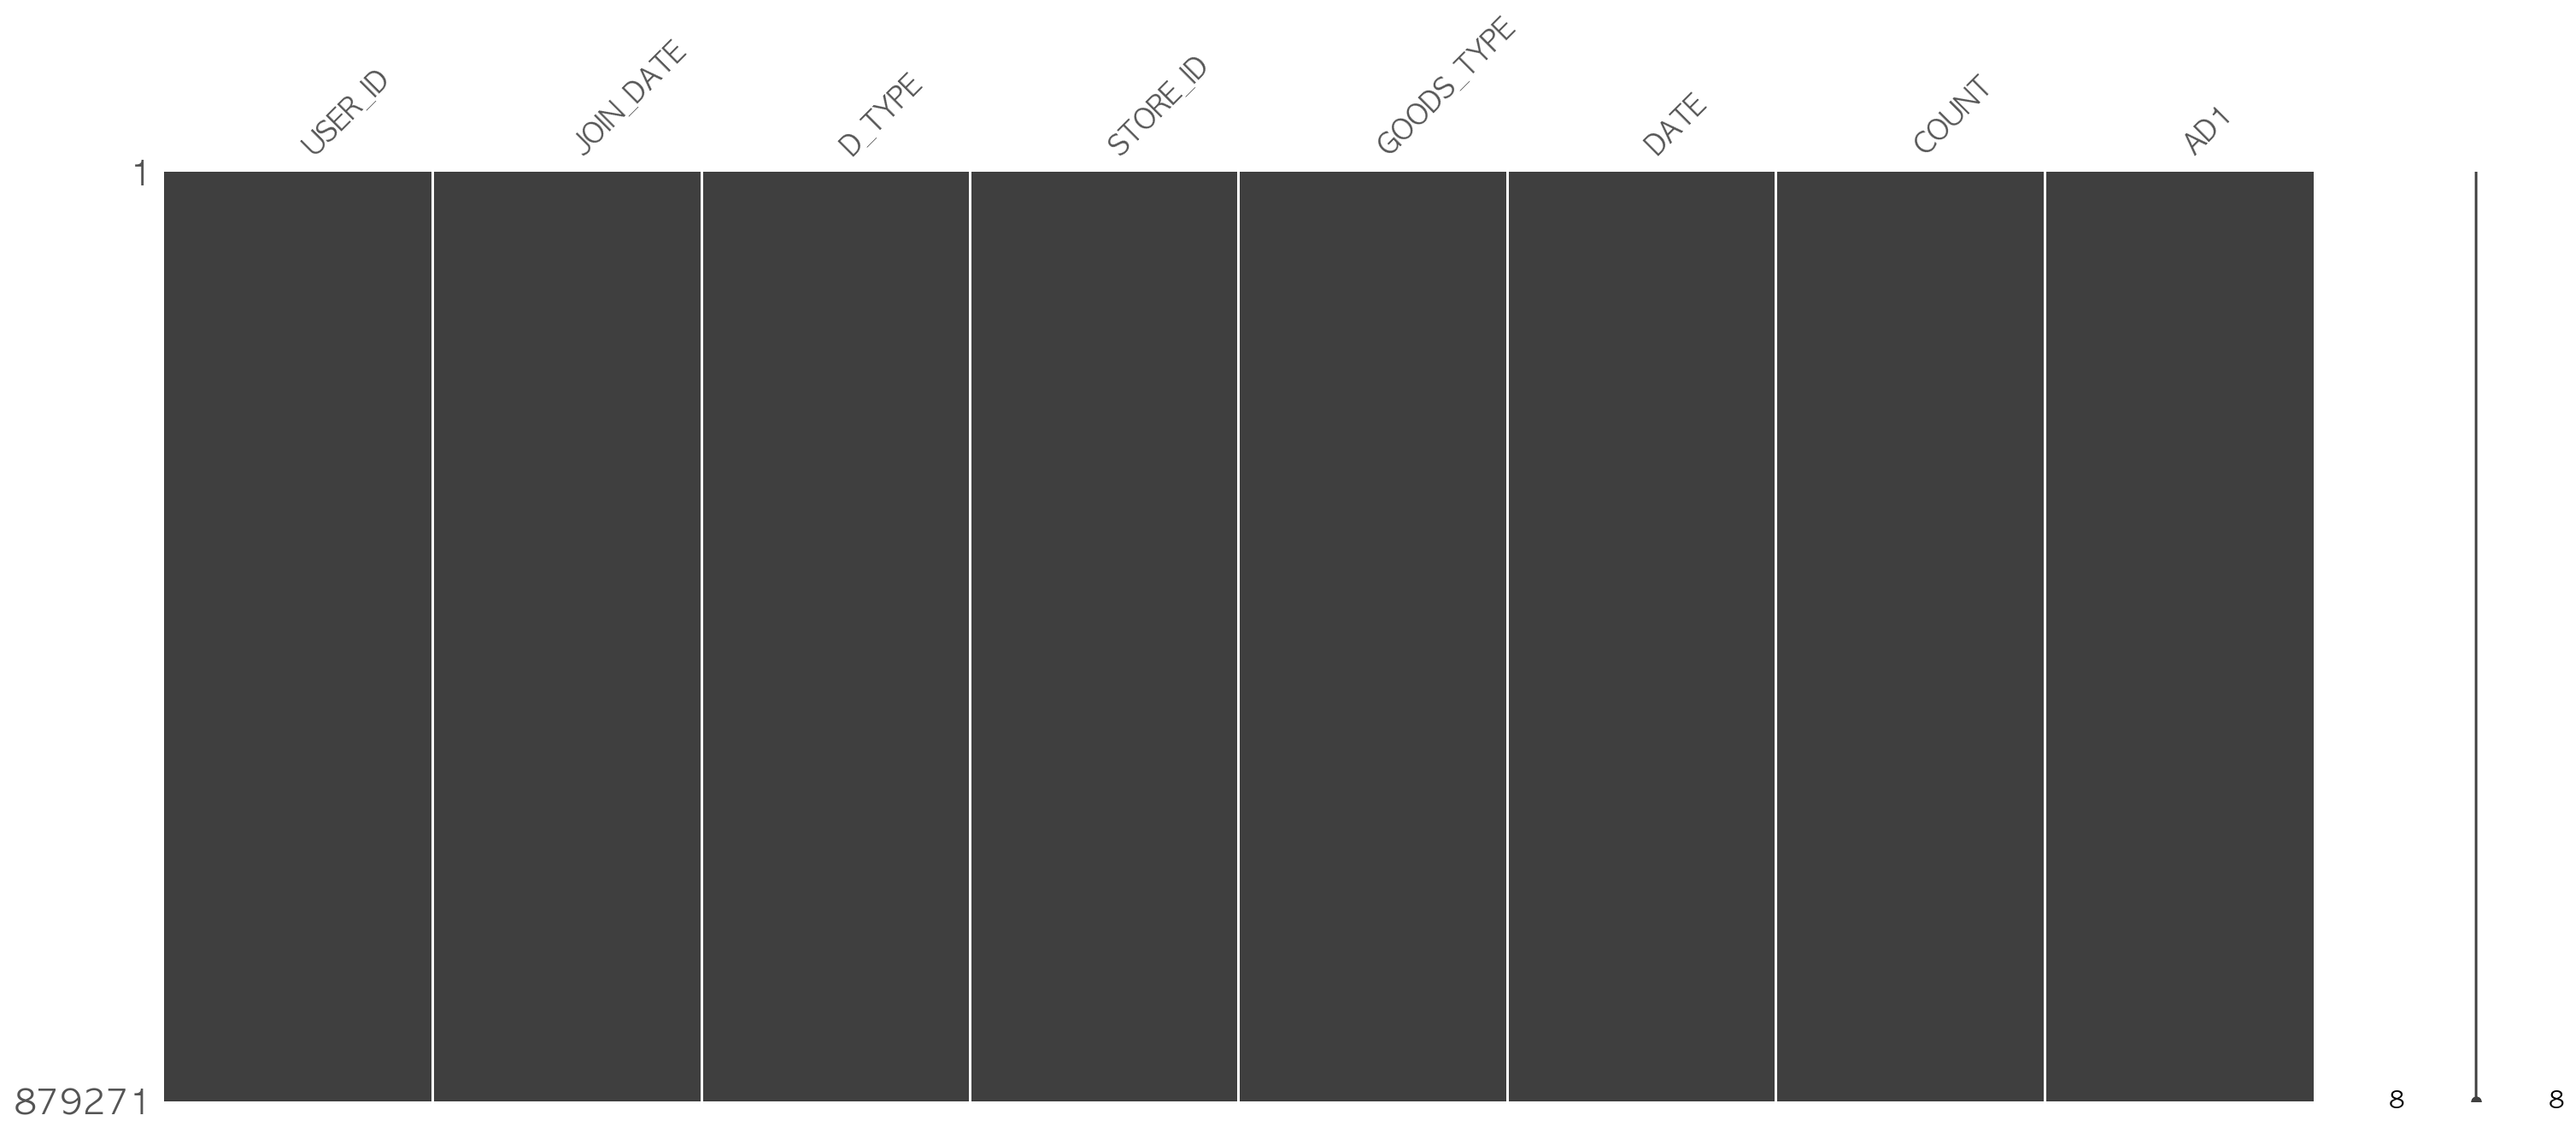

In [8]:
msno.matrix(data);

## 중복된 ID 체크하기 

In [9]:
#train/ test set 분리
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

print(f'기록된 유저ID 갯수 : {len(data["USER_ID"])}')
print(f'중복값을 제거한 고유 유저ID 갯수 :{data["USER_ID"].nunique()}')
print(f'test 데이터 셋에만 있는 고유 ID 갯수 : {len(set(test.USER_ID)-set(train.USER_ID))}')
print(f'train 데이터 셋에만 있는 고유 ID 갯수 : {len(set(train.USER_ID)-set(test.USER_ID))}')
print(f'train & test 데이터 셋에 모두 있는 고유 ID 갯수 : {len(set(train.USER_ID)&set(test.USER_ID))}')

기록된 유저ID 갯수 : 879271
중복값을 제거한 고유 유저ID 갯수 :165425
test 데이터 셋에만 있는 고유 ID 갯수 : 35165
train 데이터 셋에만 있는 고유 ID 갯수 : 89465
train & test 데이터 셋에 모두 있는 고유 ID 갯수 : 40795


## Target Value (COUNT/이용횟수 혹은 결제횟수) 분포 확인   
  
특이점
- test set의 10 ~ 20분포 < train set의 10 ~ 20 분포 
- test set에는 30 ~ 61까지의 분포가 어느정도 있는 반면 train set에는 없음 : 모델의 성능 한계점이자 성능 기준점으로 판단됨

In [10]:
print(f'train set - count=1 : {(train["COUNT"]==1).sum()}  전체 비율 : {(train["COUNT"]==1).sum()/len(train.COUNT)}')
print(f'test set  - count=1 : {(test["COUNT"]==1).sum()}  전체 비율 : {(test["COUNT"]==1).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count=2 : {(train["COUNT"]==2).sum()}  전체 비율 : {(train["COUNT"]==2).sum()/len(train.COUNT)}')
print(f'test set  - count=2 : {(test["COUNT"]==2).sum()}  전체 비율 : {(test["COUNT"]==2).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count>=3 : {(train["COUNT"]>=3).sum()}  전체 비율 : {(train["COUNT"]>=3).sum()/len(train.COUNT)}')
print(f'test set  - count>=3 : {(test["COUNT"]>=3).sum()}   전체 비율 : {(test["COUNT"]>=3).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count=10~20 : {((train["COUNT"]>=10)& (train["COUNT"]<20)).sum()}')
print(f'test set  - count=10~20 : {((test["COUNT"]>=10)& (test["COUNT"]<20)).sum()}')
print('='*80)
print(f'train set - count>=30~40 : {((train["COUNT"]>=30)& (train["COUNT"]<40)).sum()}')
print(f'test set  - count>=30~40 : {((test["COUNT"]>=30)& (test["COUNT"]<40)).sum()}')
print('='*80)
print(f'train set - count>=40~50 : {((train["COUNT"]>=40)& (train["COUNT"]<50)).sum()}')
print(f'test set  - count>=40~50 : {((test["COUNT"]>=40)& (test["COUNT"]<50)).sum()}')
print('='*80)
print(f'train set - count>=50~70 : {((train["COUNT"]>=50)& (train["COUNT"]<70)).sum()}')
print(f'test set  - count>=50~70 : {((test["COUNT"]>=50)& (test["COUNT"]<70)).sum()}')


train set - count=1 : 612896  전체 비율 : 0.9828682492514982
test set  - count=1 : 250879  전체 비율 : 0.9811765718129625
train set - count=2 : 9360  전체 비율 : 0.015010127024803593
test set  - count=2 : 4159  전체 비율 : 0.01626566337624955
train set - count>=3 : 1323  전체 비율 : 0.0021216237236982003
test set  - count>=3 : 654   전체 비율 : 0.0025577648107879794
train set - count=10~20 : 153
test set  - count=10~20 : 19
train set - count>=30~40 : 22
test set  - count>=30~40 : 27
train set - count>=40~50 : 1
test set  - count>=40~50 : 19
train set - count>=50~70 : 0
test set  - count>=50~70 : 8


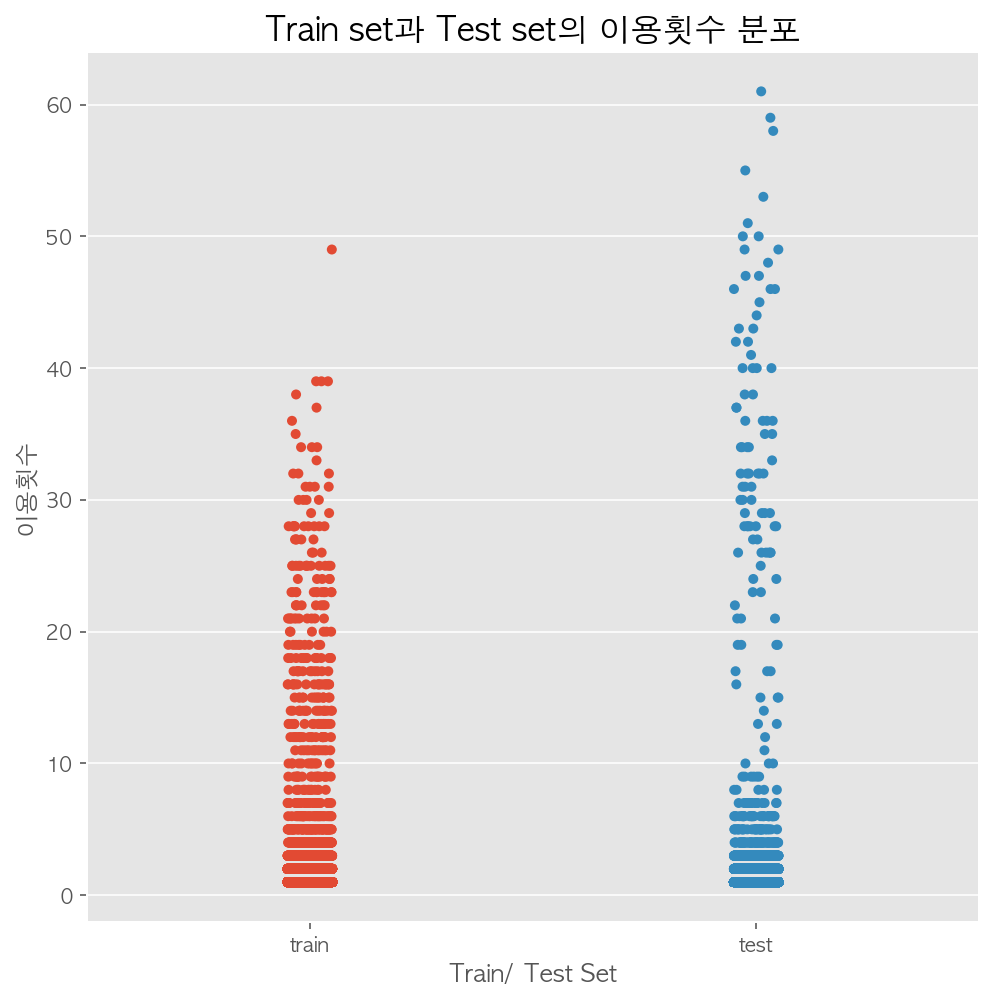

In [11]:
#날짜로 자르기 위해 'DATE'를 인덱스로 설정
data.set_index('DATE',inplace=True)
# 데이터 분리
train = data.loc[:'2020-09-30']
test = data.loc['2020-10-01':]

data1 = train[['COUNT']]
data1['data'] = 'train'
data2 = test[['COUNT']]
data2['data'] = 'test'
data3 = pd.concat([data1, data2])

plt.figure(figsize=(8,8))
sns.stripplot(y='COUNT', x='data', data=data3, jitter=0.05)
plt.title("Train set과 Test set의 이용횟수 분포", fontsize=16)
plt.ylabel("이용횟수")
plt.xlabel("Train/ Test Set")
plt.show()

## 불확실한 columns 탐구 : D_TYPE, GOODS_TYPE, STORE_ID  
- D_TYPE, GOODS_TYPE, STORE_ID 값들이 불분명하여 요일 정보와 함께 분포 탐구를 시도함.   
  
**STORE_ID**  
- 이용횟수가 상위 60곳의 주차장에서 2000번부터 17000번까지 매우 빈번한 경우도 있었지만 대략 60곳의 주차장은 오직 한번의 이용횟수만 있어 STORE_ID의 빈도수에 큰 격차가 존재.  
  
  
**<추정 결과>**  
D_TYPE = DAY_TYPE : n시간권, 당일권, 월정액권   
GOODS_TYPE : 평일 주간/야간, 주말 주간/야간 
> - GOODS_TYPE만 주중과 주말의 차이가 존재
> - 특히 A,C 그리고 B,D가 나뉘어 주말 기준으로 주중과 차이 존재
> - 주차 어플에서 주중 주말 차이가 나는 건 평일권(주간,야간), 주말권(주간,야간)이지 않을까 판단됨  

STORE_ID : 제휴 주차장 고유넘버 
> - 모두의 주차장 앱을 확인한 결과 '공유주차장'에 고유의 숫자가 부여되어 있음을 확인.  
> - 공유주차장의 고유숫자는 노출되어 있는 반면 제휴주차장은 노출되어 있지 않음을 확인.  
> - 따라서 store_id는 제휴주차장의 고유넘버라고 추정됨.  
> - 또한 공유주차장의 고유넘버 앞 2~3자리가 해당 주차장의 지역/구역 넘버, 나머지 뒷 3자리가 등록 순서를 의미하는 것으로 추정되므로 store_id를 지역 정보로 활용하기로 함 

In [12]:
# 병훈님 
ndata['DATE']=pd.to_datetime(ndata['DATE'])
ndata['dayofweek'] = [k for k in ndata['DATE'].dt.dayofweek]

pd.crosstab(ndata['dayofweek'], 
            ndata['GOODS_TYPE'], margins=True).style.background_gradient(cmap ='Oranges')

In [13]:
#병훈님 
pd.crosstab(ndata['dayofweek'], 
            ndata['GOODS_TYPE'], margins=True).style.background_gradient(cmap ='Oranges')

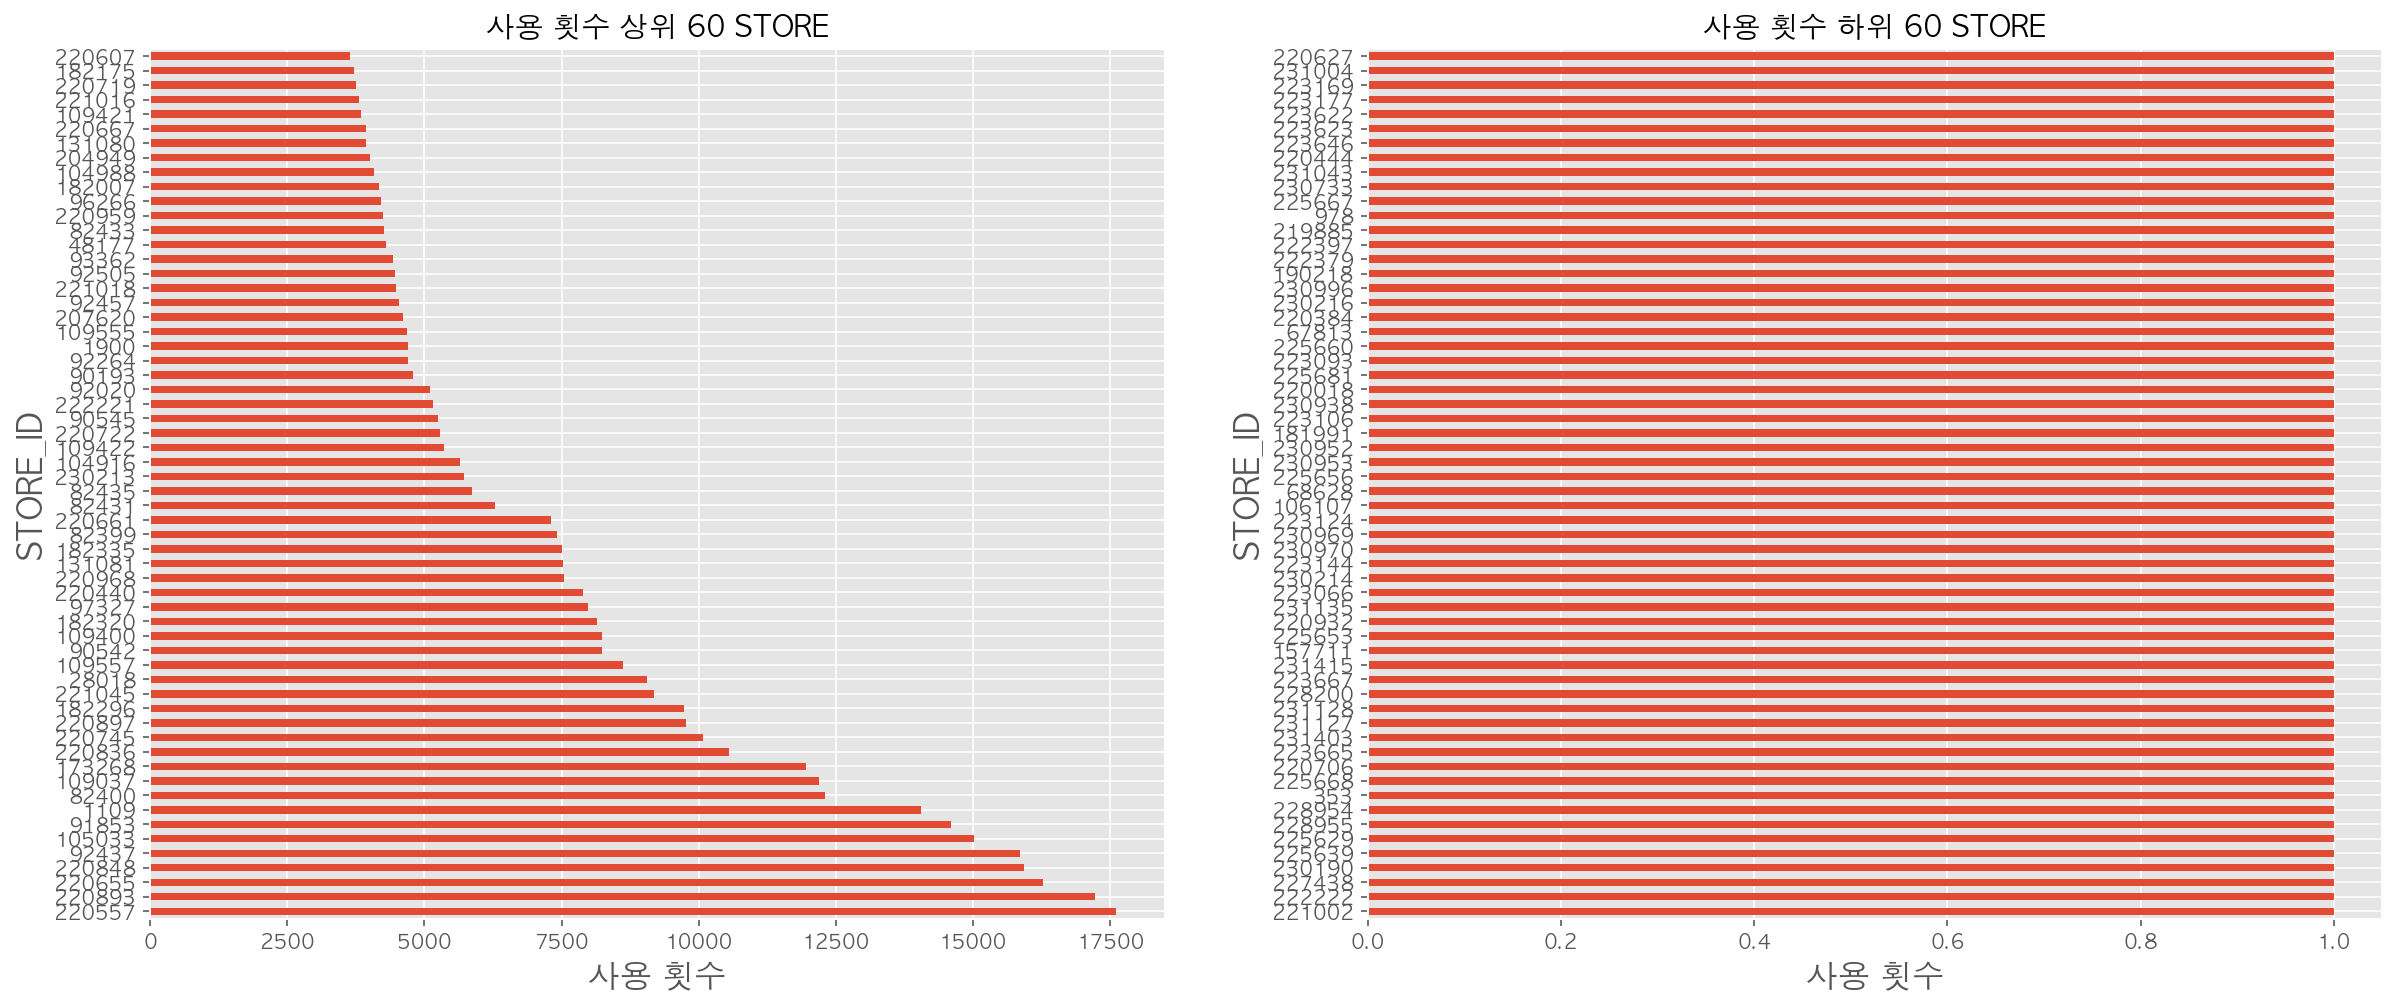

In [14]:
# 근웅님
fig = plt.figure(figsize=(20,8))
fig.add_subplot(1,2,1)
ndata.groupby('STORE_ID').count()['USER_ID'].sort_values(ascending=False)[:60].plot.barh(title='사용 횟수 상위 60 STORE')
plt.ylabel('STORE_ID', fontsize=16)
plt.xlabel('사용 횟수', fontsize=16)
fig.add_subplot(1,2,2)
ndata.groupby('STORE_ID').count()['USER_ID'].sort_values(ascending=False)[-60:].plot.barh(title='사용 횟수 하위 60 STORE')
plt.ylabel('STORE_ID', fontsize=16)
plt.xlabel('사용 횟수', fontsize=16)
plt.show()

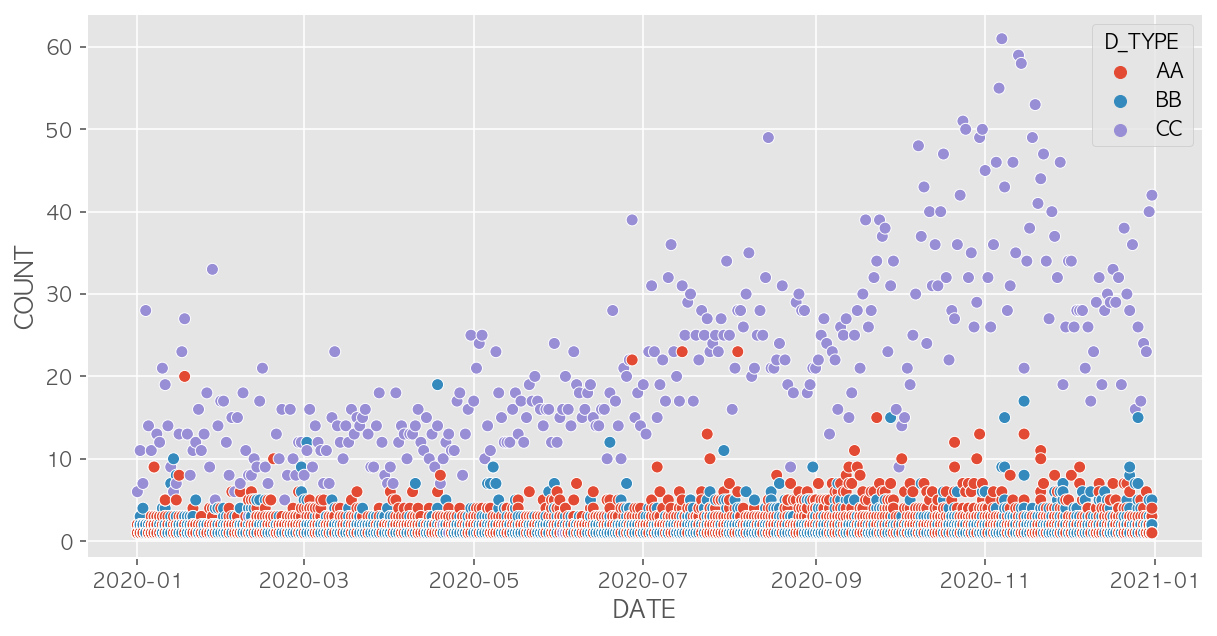

In [15]:
#D_TYPE별 유저별 COUNT 분포 태영님
plt.figure(figsize=(10,5))
sns.scatterplot(data=ndata, x='DATE', y='COUNT', hue='D_TYPE')
plt.show();

# EDA   
## 시간 요인과 이용횟수 
### 분기별 이용횟수  
- 주기성을 보이지만 분석의 목적이 test set을 맞추는 것이므로 주기성을 활용한 시계열 분석은 필요하지 않다는 판단

In [16]:
# 필요한 피처들 추가 태영님
class Calendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('KR_New Year1', month=1, day=24),
        Holiday('KR_New Year2', month=1, day=25),
        Holiday('KR_New Year3', month=1, day=26),
        Holiday('3.1', month=3, day=1),
        Holiday('Buddha Day', month=4, day=30),
        Holiday('Memorial Day', month=6, day=6),
        Holiday('Liberation Day', month=8, day=15),
        Holiday('KR_Thanksgiving1', month=9, day=30),
        Holiday('KR_Thanksgiving2', month=10, day=1),
        Holiday('KR_Thanksgiving3', month=10, day=2),
        Holiday('National Foundation Day', month=10, day=3),
        Holiday('Hangul Day', month=10, day=9),
        Holiday('Christmas', month=12, day=25)
    ]
       
dr = pd.date_range(start='2020-01-01', end='2020-12-31')
cal = Calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
ndata['Holiday'] = ndata['DATE'].isin(holidays)
ndata['Month'] = [k for k in ndata['DATE'].dt.month]
ndata['Day'] = [k for k in ndata['DATE'].dt.day]
ndata['dayofweek'] = [k for k in ndata['DATE'].dt.dayofweek]
ndata['JOIN_DATE'] = pd.to_datetime(ndata['JOIN_DATE'])
ndata['ELAPSED_DAY'] = (ndata['DATE']-ndata['JOIN_DATE']).dt.days

for i in range(len(ndata)):
    if ndata['Day'][i] == 6:
        ndata['Holiday'][i] = True
ndata['Weekend_indi'] = 0
ndata['EveryDay'] = ndata.loc[ndata['Day'].isin([4,5]), 'Weekend_indi'] =1

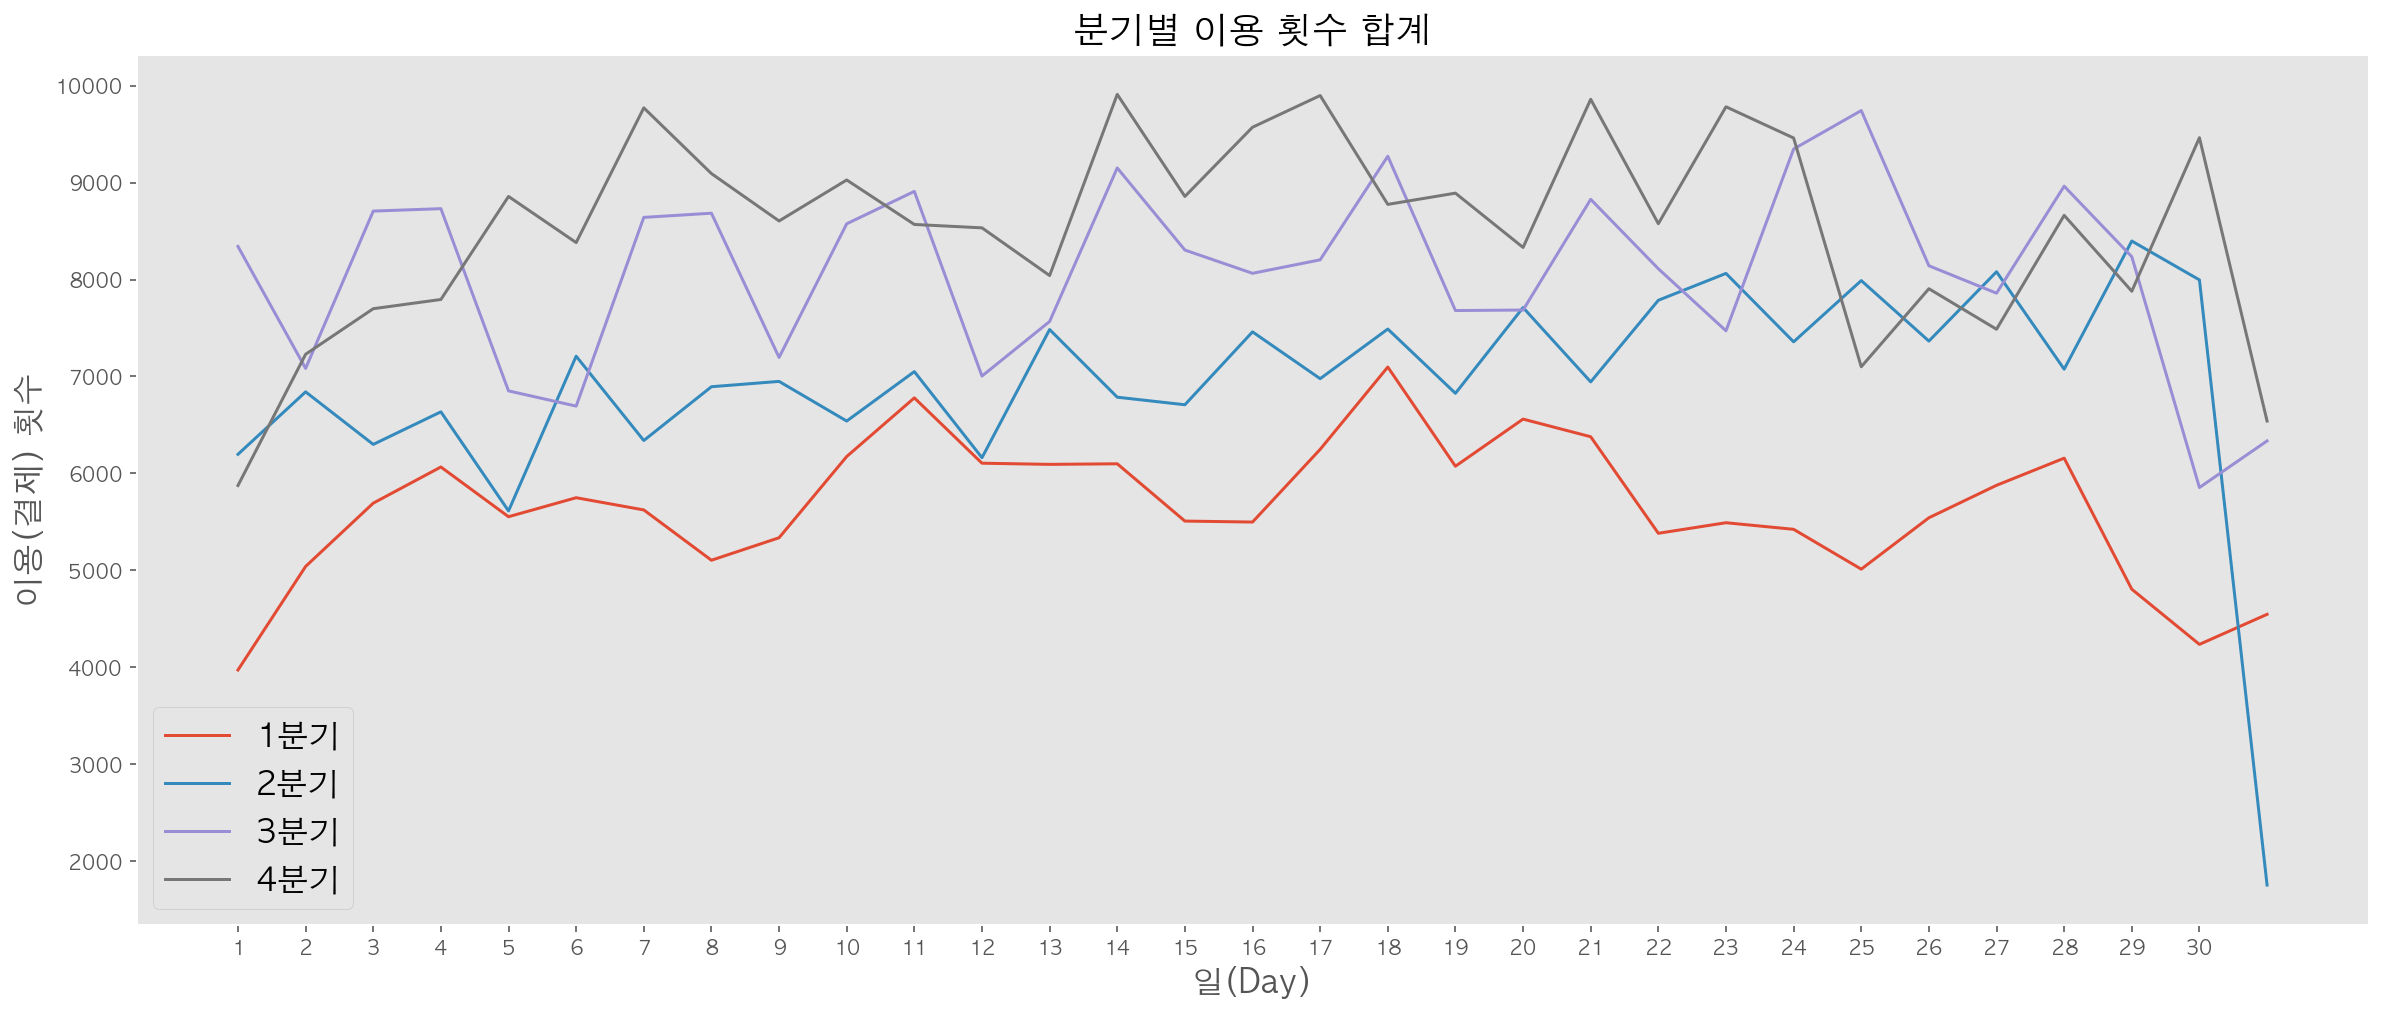

In [17]:
#분기별 조아라  
ndata['quartile']=ndata['Month'].apply(lambda x : 1 if x<=3 else 2 if (x>3) & (x<=6) else 3 if (x>6) & (x<=9) else 4)

parking_1_4=ndata[ndata.quartile==1]['COUNT'].groupby(ndata.Day).sum()
parking_2_4=ndata[ndata.quartile==2]['COUNT'].groupby(ndata.Day).sum()
parking_3_4=ndata[ndata.quartile==3]['COUNT'].groupby(ndata.Day).sum()
parking_4_4=ndata[ndata.quartile==4]['COUNT'].groupby(ndata.Day).sum()

plt.figure(figsize=(20,8))
sns.lineplot(x=parking_1_4.index, y=parking_1_4.values)
sns.lineplot(x=parking_2_4.index, y=parking_2_4.values)
sns.lineplot(x=parking_3_4.index, y=parking_3_4.values)
sns.lineplot(x=parking_4_4.index, y=parking_4_4.values)

plt.grid(linewidth=1)
plt.xticks(np.arange(1, 31, step=1))
plt.legend(['1분기', '2분기','3분기','4분기'], loc='best', fontsize=16)
plt.title('분기별 이용 횟수 합계', fontsize=18)
plt.ylabel('이용(결제) 횟수', fontsize=16)
plt.xlabel('일(Day)', fontsize=16)
plt.show();

### 날짜별 이용횟수   
- 일년 동안 하루 몇 번의 결제가 이루어졌는지 count의 합을 시계열 그래프로 표현.
- 공휴일과 일요일의 count수가 상대적으로 낮음  
- 결제건수가 11월까지 꾸준히 증가하는 추세를 보이다 이후 주춤

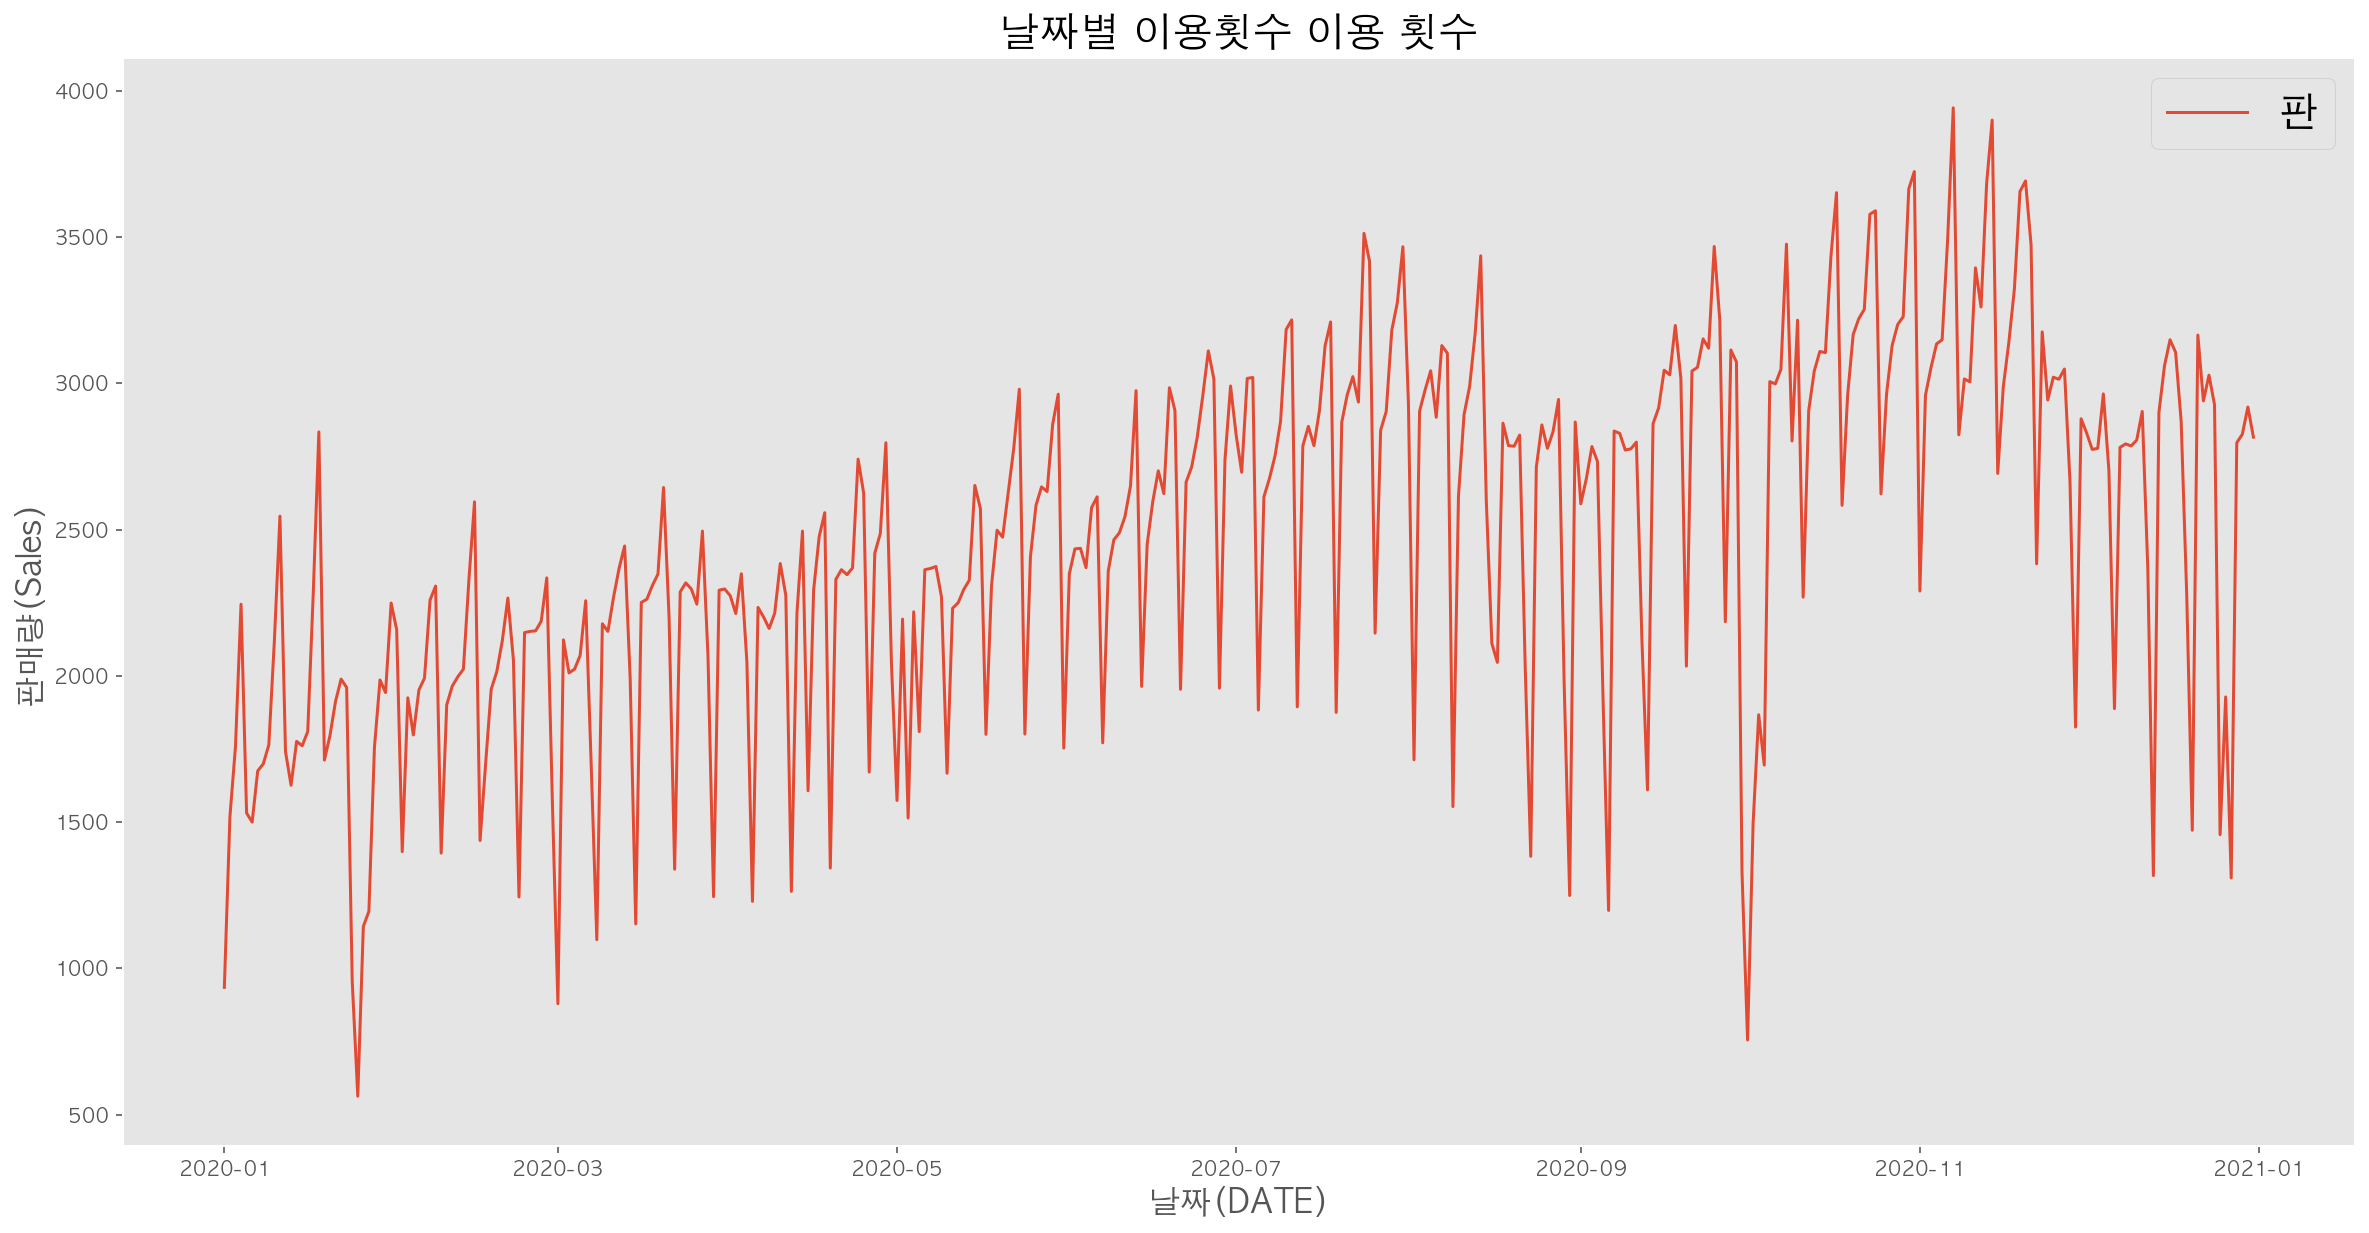

In [18]:
# 해강님 
sales_2020 = ndata.groupby(ndata['DATE'])['COUNT'].sum()
plt.figure(figsize=(20,10))
sns.lineplot(sales_2020.index, sales_2020.values)
plt.grid(linewidth=1)
plt.legend('판매량',loc='best', fontsize=20)
plt.title('날짜별 이용횟수 이용 횟수', fontsize=20)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('날짜(DATE)', fontsize=16)
plt.show()

### 요일별 사용 현황   
- 앱을 가장 많이 사용하는 요일 : 금요일  
- 앱을 가장 적게 사용하는 요일 : 일요일  
- 요일 별 count 중 높은 수치 : 금요일, 토요일

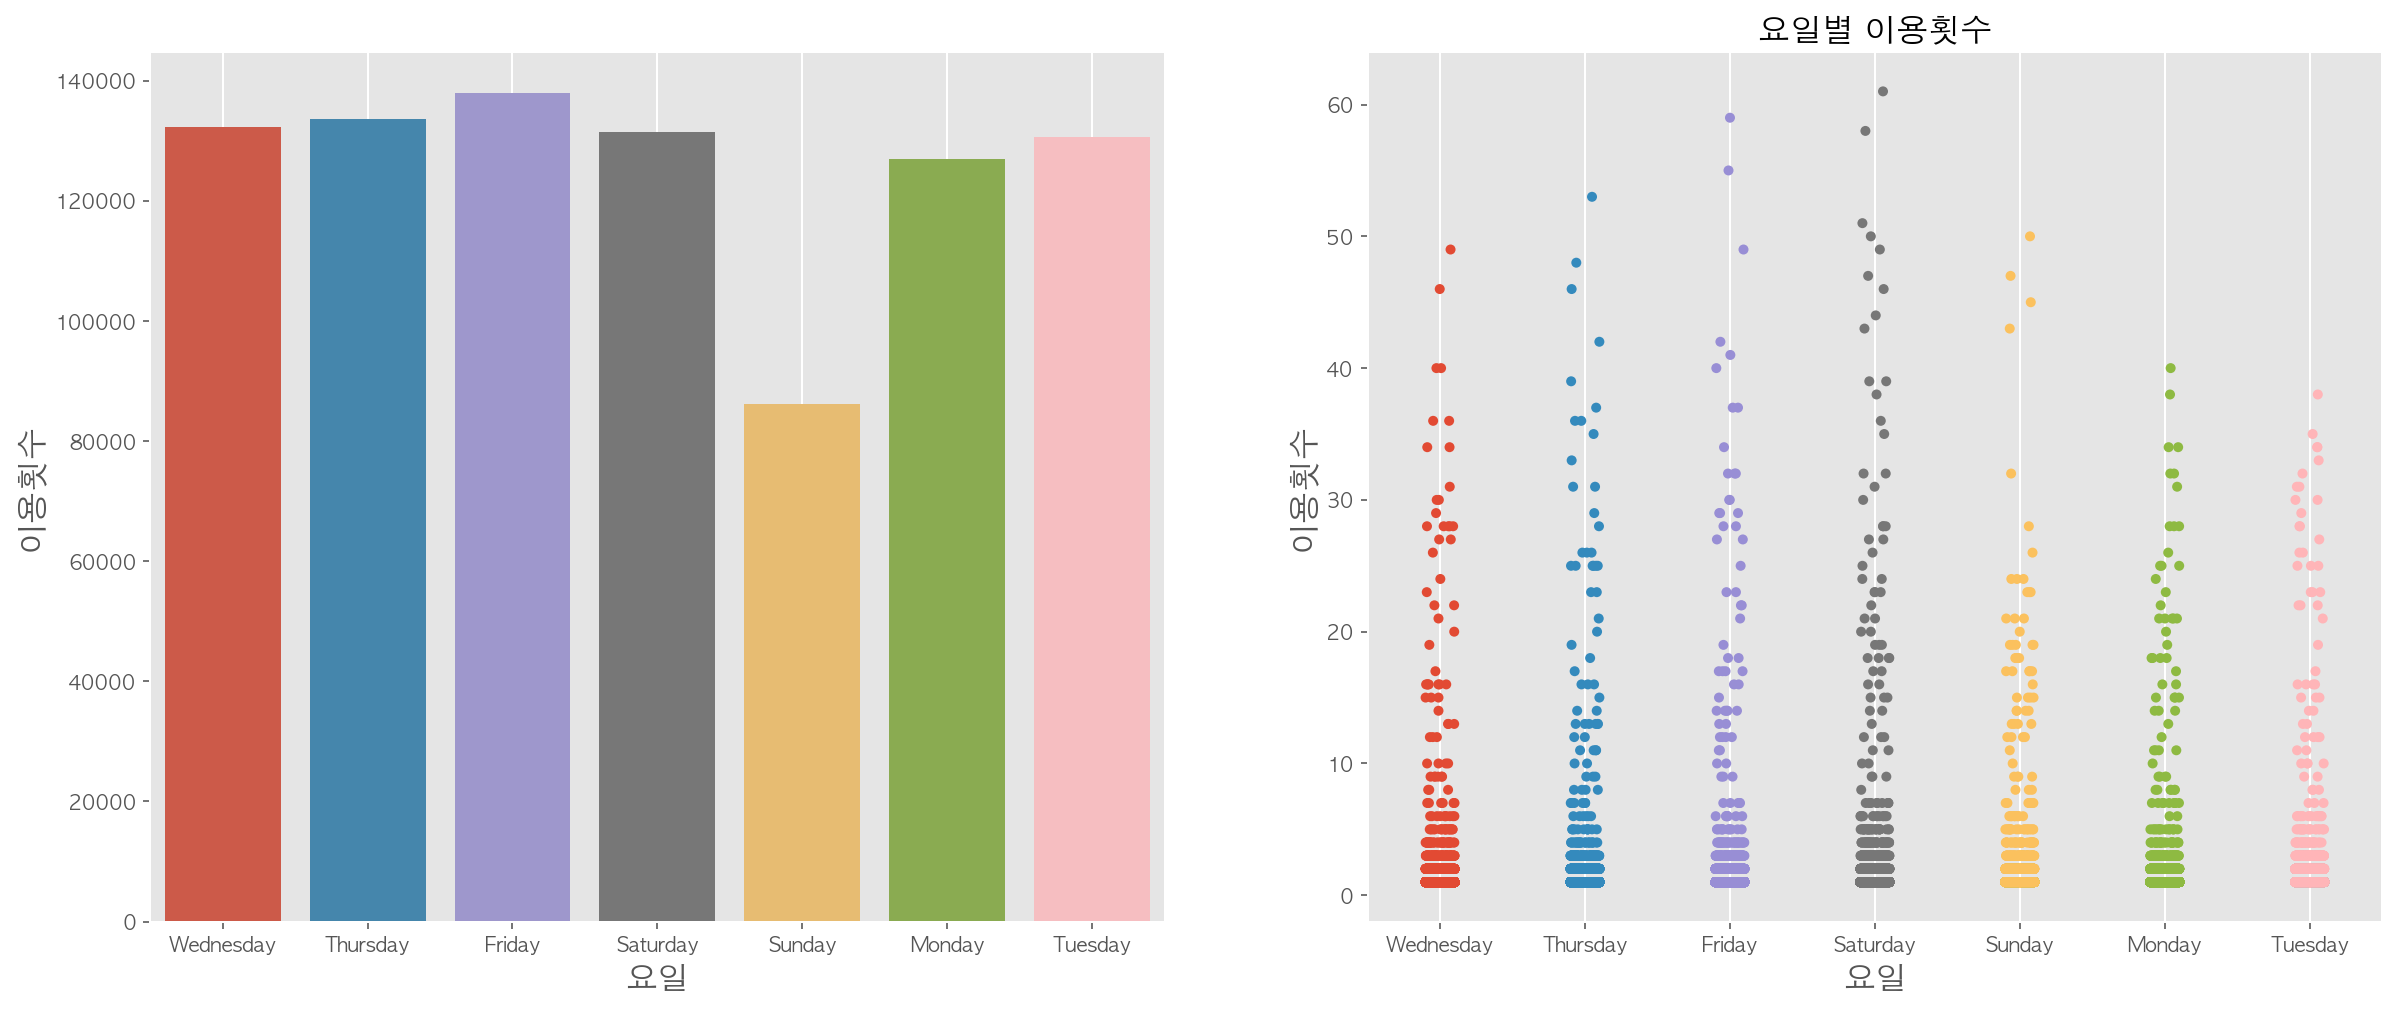

In [19]:
#근웅님 
ndata['DoW'] = ndata['DATE'].dt.day_name()

fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.countplot(data=ndata, x='DoW', ax = fig.add_subplot(gs[0,0]))
plt.grid(linewidth=1)
plt.ylabel('이용횟수', fontsize=16)
plt.xlabel('요일', fontsize=16)

sns.stripplot(x=ndata['DoW'], y=ndata['COUNT'], ax=fig.add_subplot(gs[0,1]))
plt.grid(linewidth=1)
plt.ylabel('이용횟수', fontsize=16)
plt.xlabel('요일', fontsize=16)
plt.title('요일별 이용횟수', fontsize=16)
fig.show()

### 공휴일 이용횟수

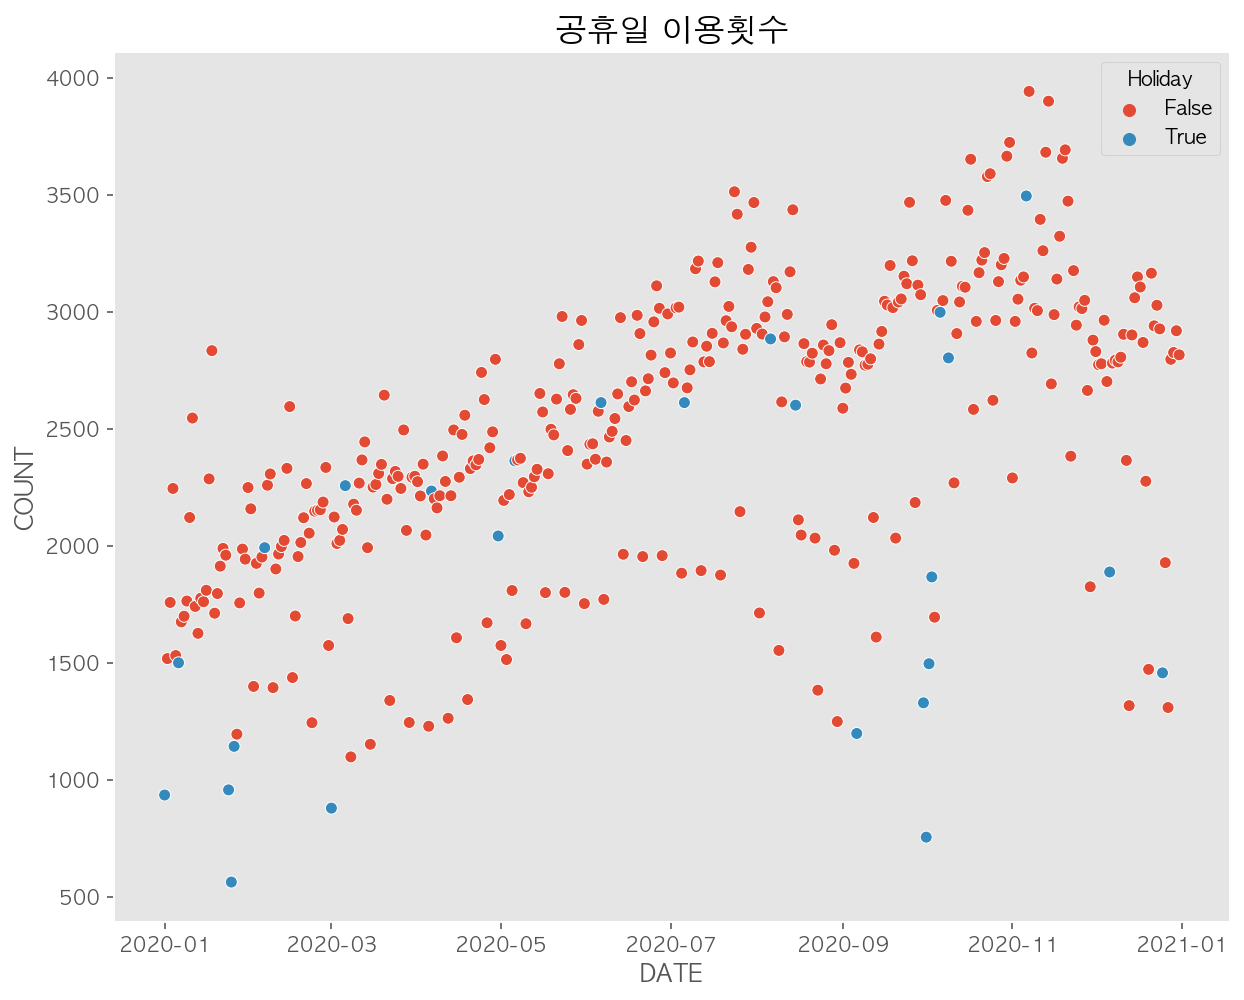

In [20]:
# 태영님 
공휴일 = ndata.groupby(['DATE','Holiday'])['COUNT'].sum().reset_index()
f=plt.figure(figsize=(10,8))
sns.scatterplot(data=공휴일, x='DATE', y='COUNT', hue='Holiday')
plt.grid(linewidth=1)
plt.title('공휴일 이용횟수', fontsize=16);

### 이용일 기준 가입 기간별 이용횟수   
- 1970년 가입자가 존재함. 잘못 기재된 것으로 추정되는데 그 수가 작지 않아 막연하게 배재할 수 없다고 판단하여 드롭하지 않고 분석하기로 함  
- 가입일수에 매우 큰 이상치들이 존재함. 이를 제외하여 그래프를 그려보니 특정 구간에서 양의 상관성을 가지는 경향을 띔.

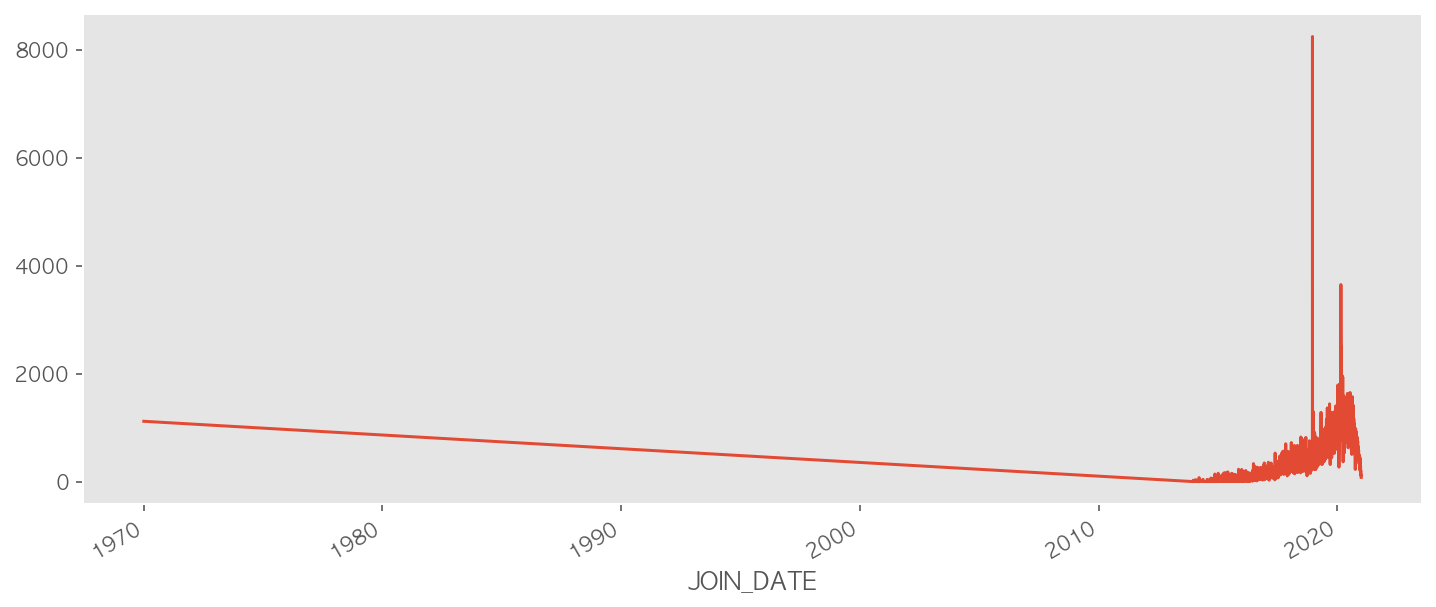

In [21]:
#태영님 
join=ndata.groupby(['JOIN_DATE'])['COUNT'].sum()
join.transpose().plot(figsize=(12,5))
plt.grid(linewidth=1)

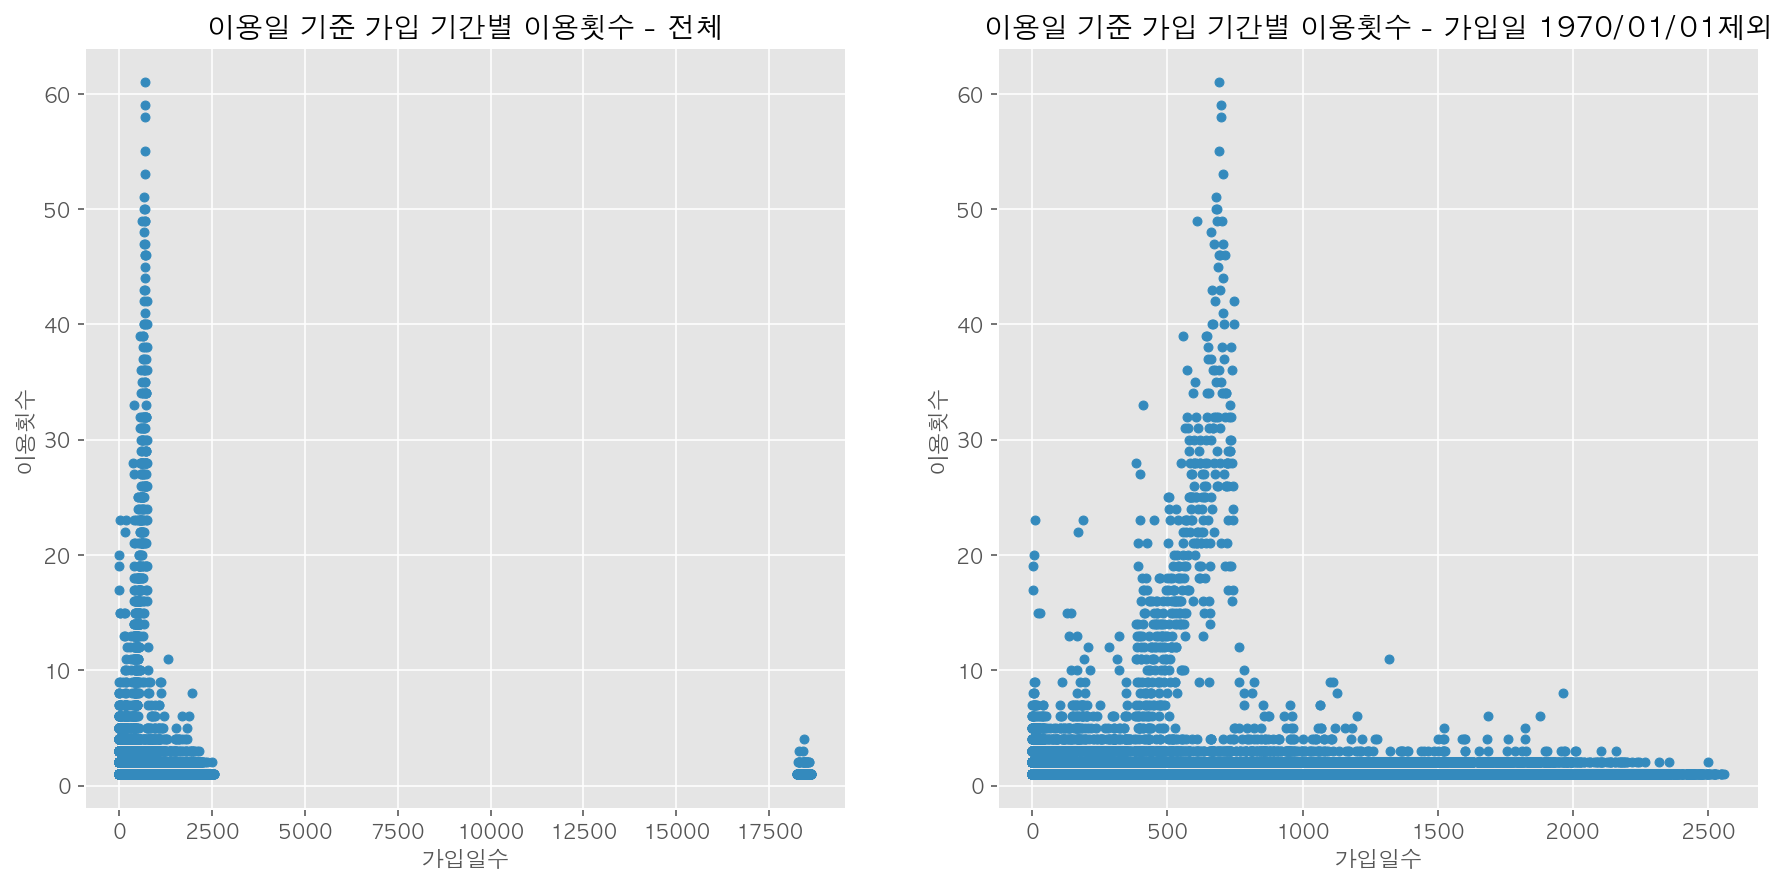

In [22]:
#나영님
fig, axes = plt.subplots(1, 2, figsize=(15,7))
ndata.plot(kind='scatter', x='ELAPSED_DAY', y='COUNT', ax=axes[0])
axes[0].set_title('이용일 기준 가입 기간별 이용횟수 - 전체',  fontsize=14)
axes[0].set_xlabel('가입일수', fontsize=11)
axes[0].set_ylabel('이용횟수', fontsize=11)
ndata[ndata['JOIN_DATE']>'1970-01-01'].plot(kind='scatter', x='ELAPSED_DAY', y='COUNT', ax=axes[1])
axes[1].set_title('이용일 기준 가입 기간별 이용횟수 - 가입일 1970/01/01제외', fontsize=14)
axes[1].set_ylabel('이용횟수', fontsize=11)
axes[1].set_xlabel('가입일수', fontsize=11)
plt.show()

## 장소 요인과 이용횟수  

### AD1별 이용횟수 

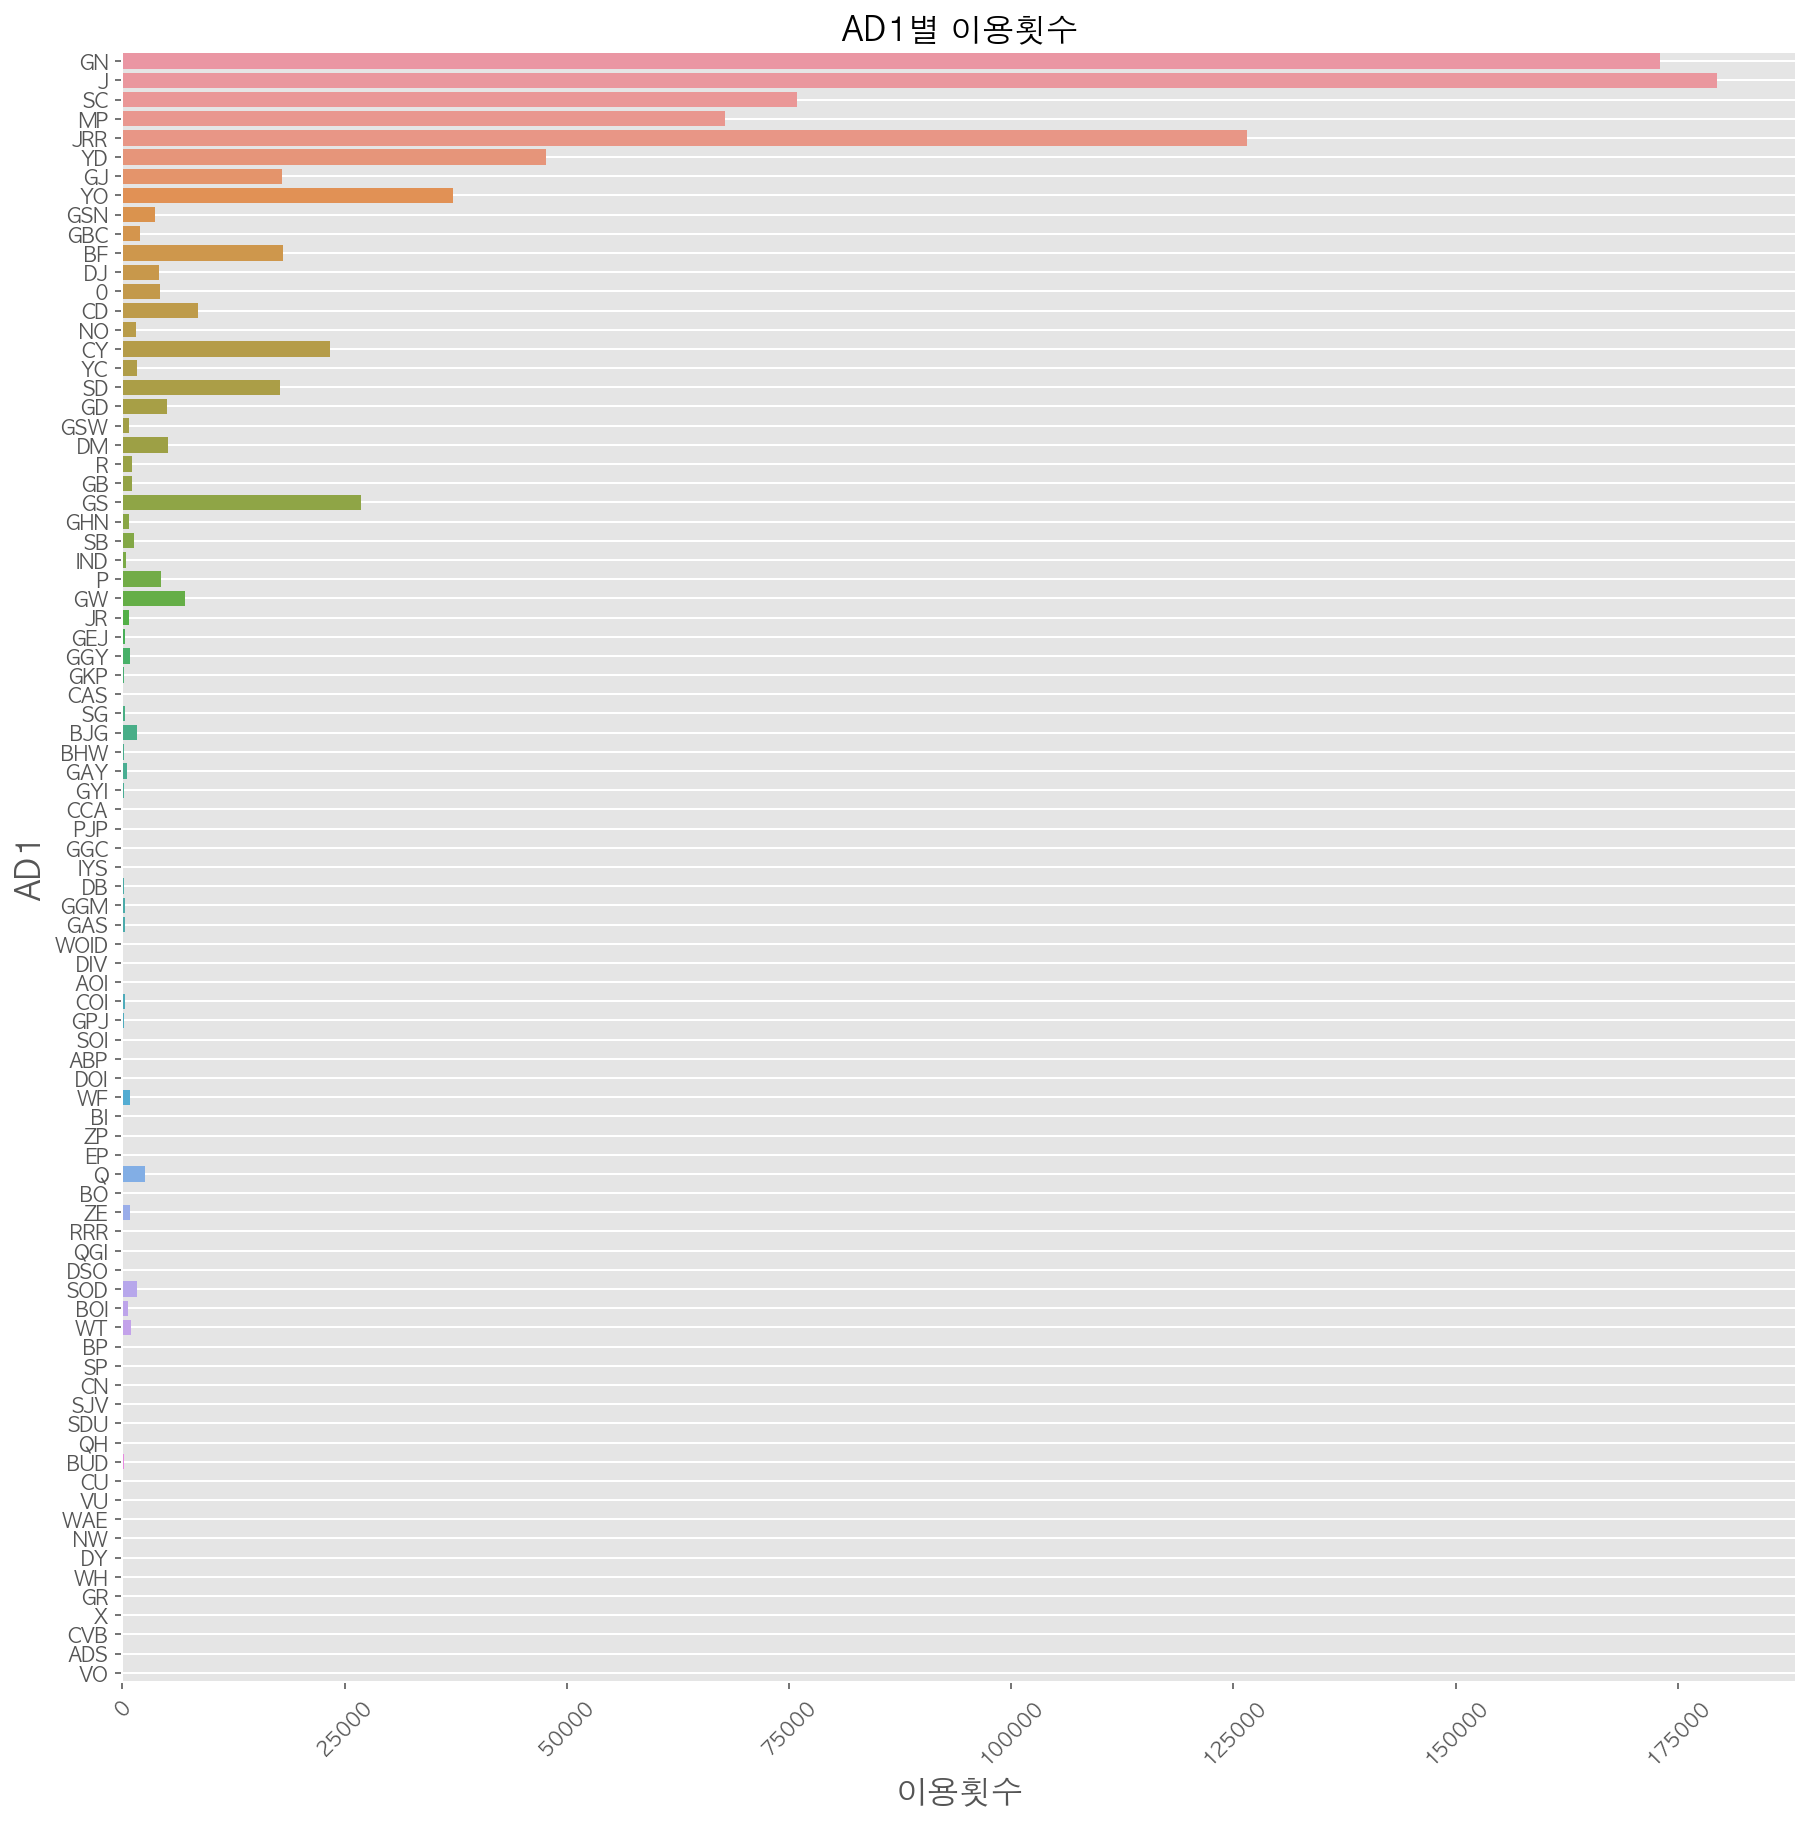

In [23]:
#병훈님
f=plt.figure(figsize = (15,15))
sns.barplot(data = ndata, x = 'COUNT',y ='AD1',estimator =len)
plt.xticks(rotation =45)
plt.yticks(fontsize=10)
plt.grid(linewidth=1)
plt.title('AD1별 이용횟수', fontsize=16)
plt.ylabel('AD1', fontsize=16)
plt.xlabel('이용횟수', fontsize=16)
plt.show()

## 유저 이용 패턴 요인과 이용횟수  
### GOODS_TYPE별 이용횟수  
- GOODS TYPE별로 이용 횟수간 차이가 존재함.  A와 나머지 유형간 차이가 두드러짐

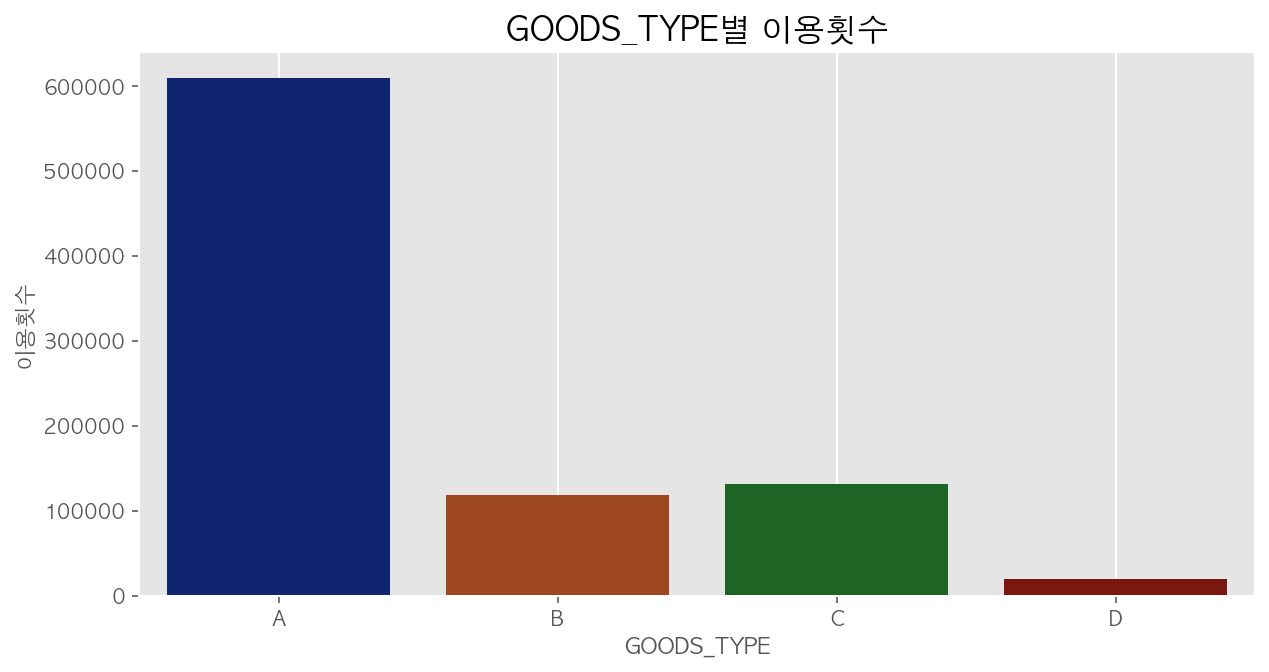

In [24]:
#나영님 
goodstype_count = ndata['COUNT'].groupby(ndata['GOODS_TYPE']).count()
plt.figure(figsize=(10,5))
sns.barplot(goodstype_count.index, goodstype_count.values, palette='dark')
plt.grid(linewidth=1)
plt.title('GOODS_TYPE별 이용횟수', fontsize=16)
plt.ylabel('이용횟수', fontsize=11)
plt.xlabel('GOODS_TYPE', fontsize=11)
plt.show()

## 환경 요인과 이용횟수 - 미세먼지  
- 일별 평균 대기오염도 와 COUNT 분포 : 일별로 미세먼지/초미세먼지 정도와 총 이용건수의 분포
- 공공API - 미세먼지 경보 발령현황과 COUNT 분포 : 서울, 경기지역의 미세먼지 경보 발령현황(주의보/경보)과 해당일의 미세먼지 농도와 총 이용건수의 분포
- 대기 오염도와 이용 횟수는 큰 상관관계는 없으나 약한 수준의 반비례 관계 

In [25]:
dust_big['측정일시'] = pd.to_datetime(dust_big['측정일시'],format='%Y%m%d')
dust_big.groupby('측정소명').count()

#측정소명 강남구로 통일
dust_big=dust_big[dust_big['측정소명']=='강남구']
merged_big=pd.DataFrame(ndata.groupby('DATE')['COUNT'].sum()).merge(dust_big,left_on='DATE', right_on='측정일시')

In [26]:
#우주님
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=merged_big['측정일시'], y=merged_big['COUNT'], name="COUNT data", line=dict(color="LightSeaGreen")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=merged_big['측정일시'], y=merged_big['미세먼지(㎍/㎥)'], name="미세먼지 data", line=dict(color="gray")),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=merged_big['측정일시'], y=merged_big['초미세먼지(㎍/㎥)'], name="초미세먼지 data", line=dict(color="brown")),
    secondary_y=True,
)

fig.update_layout(
    title_text="일별 평균 대기 오염도와 이용 횟수 분포"
)

fig.update_xaxes(title_text="DATE")

fig.update_yaxes(title_text="이용 횟수", secondary_y=False)
fig.update_yaxes(title_text="미세먼지/초미세먼지", secondary_y=True)

fig.show()

In [27]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=merged_big['측정일시'], y=merged_big['COUNT'], name="COUNT data", line=dict(color="LightSeaGreen")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=dust_small['발령일'], y=dust_small['발령농도'], name="미세먼지",mode="markers" ),
    secondary_y=True,
)

fig.update_layout(
    title_text="공공API - 미세먼지 경보 발령현황과 COUNT 분포"
) 

fig.update_xaxes(title_text="DATE")

fig.update_yaxes(title_text="이용 횟수", secondary_y=False)
fig.update_yaxes(title_text="미세먼지 농도", secondary_y=True)

fig.show()

## 교통량과 이용횟수

In [28]:
temp=ndata.copy()
temp['DATE']=temp['DATE'].dt.strftime('%Y-%m-%d')
df_morafic=pd.merge(temp,trans, how='left', left_on='DATE', right_on='DATE')
df_moraficm=df_morafic[['합계_x', 'COUNT','DATE']].groupby(['DATE'], as_index = True).mean()
df_modura2 = ndata[['합계', 'COUNT','DATE']].groupby(['DATE'], as_index = True).mean()

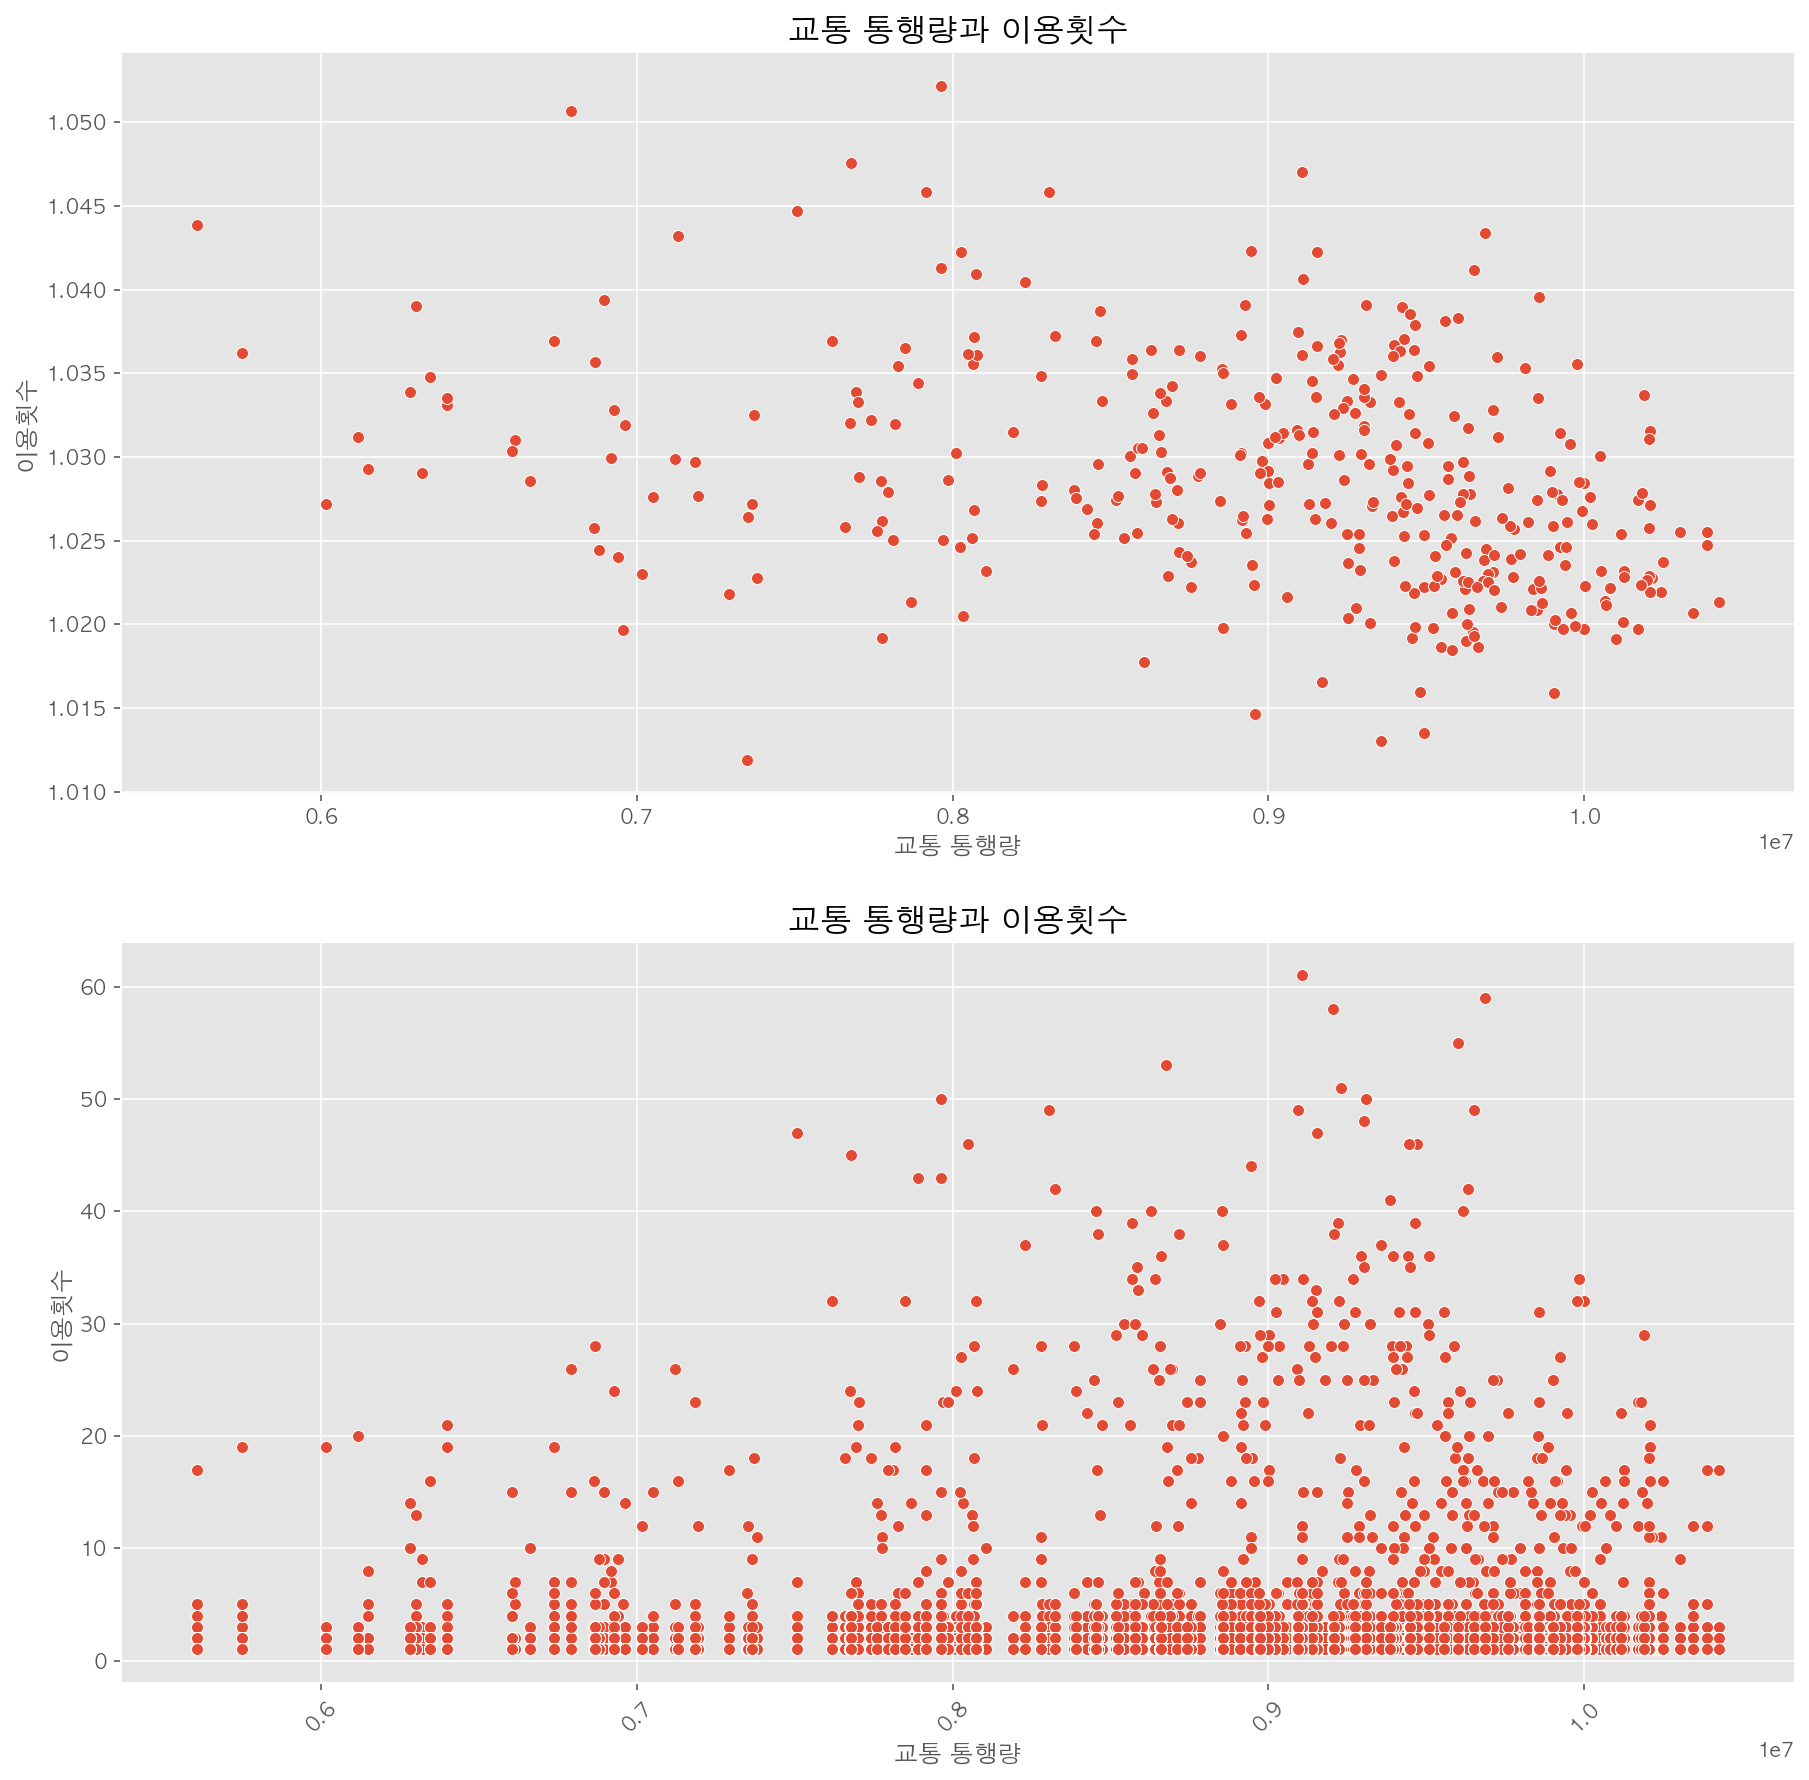

In [29]:
#병훈님 
f, axs = plt.subplots(2,1, figsize = (15,15))
sns.scatterplot(data = df_moraficm, x = '합계_x',y = 'COUNT',estimator =len, palette="deep", ax=axs[0])
plt.xticks(rotation =45)
axs[0].set_title('교통 통행량과 이용횟수', fontsize=16)
axs[0].set_ylabel('이용횟수')
axs[0].set_xlabel('교통 통행량')

sns.scatterplot(data = ndata, x = '합계',y = 'COUNT',estimator =len, ax=axs[1])
plt.xticks(rotation =45)
axs[1].set_title('교통 통행량과 이용횟수', fontsize=16)
axs[1].set_ylabel('이용횟수')
axs[1].set_xlabel('교통 통행량')
plt.show()

# 추가 요인 뽑아내기 : STORE_ID 활용하여 유저 이용 패턴 정보 추가
- moving : 유저별 이용한 store의 총 갯수(중복 허용 X)  
- parking_area : 유저가 이용한 store의 지역/구역. store_id에서 앞 2~3자리 추출. store_id가 3자리 이하인 것은 0으로 일괄처리(정보 알 수 없음으로 분리)  
- parking_range : 유저가 방문한 지역/구역의 총 갯수 (중복 허용 X)  
- frequency : 유저별 데이터셋에 나타난 빈도수 (빈도수가 클수록 모두의 주차장을 자주 이용하는 유저라고 해석 가능)

In [30]:
ndata['moving'] = ndata.groupby('USER_ID')['STORE_ID'].transform('nunique')
ndata['parking_area']=ndata['STORE_ID'].astype(str).str[:-3]
ndata['parking_area'].replace('', '0', inplace=True)
ndata['parking_range']=ndata.groupby('USER_ID')['parking_area'].transform('nunique')
ndata['frequency']=ndata.groupby('USER_ID')['USER_ID'].transform('count')

# Correlation  & Feature Selection  
- count와 큰 상관관계를 가지는 피처는 없는 것으로 보임.  
- 하지만 상관관계가 없다고 해서 인과성이 없다고 해석할 수 없고, EDA로 살펴본 거의 모든 피처에서 COUNT가 주의할 만한 분포를 보여주고 있음. 이에 더해 경험에 근거한 여러 의견들을 종합해 본 결과 해당 피처들이 주차 수요와 연결 고리가 있을 것이라 판단함.   
- 따라서 소수의 불필요한 피처를 제외하고 모두 넣기로 함

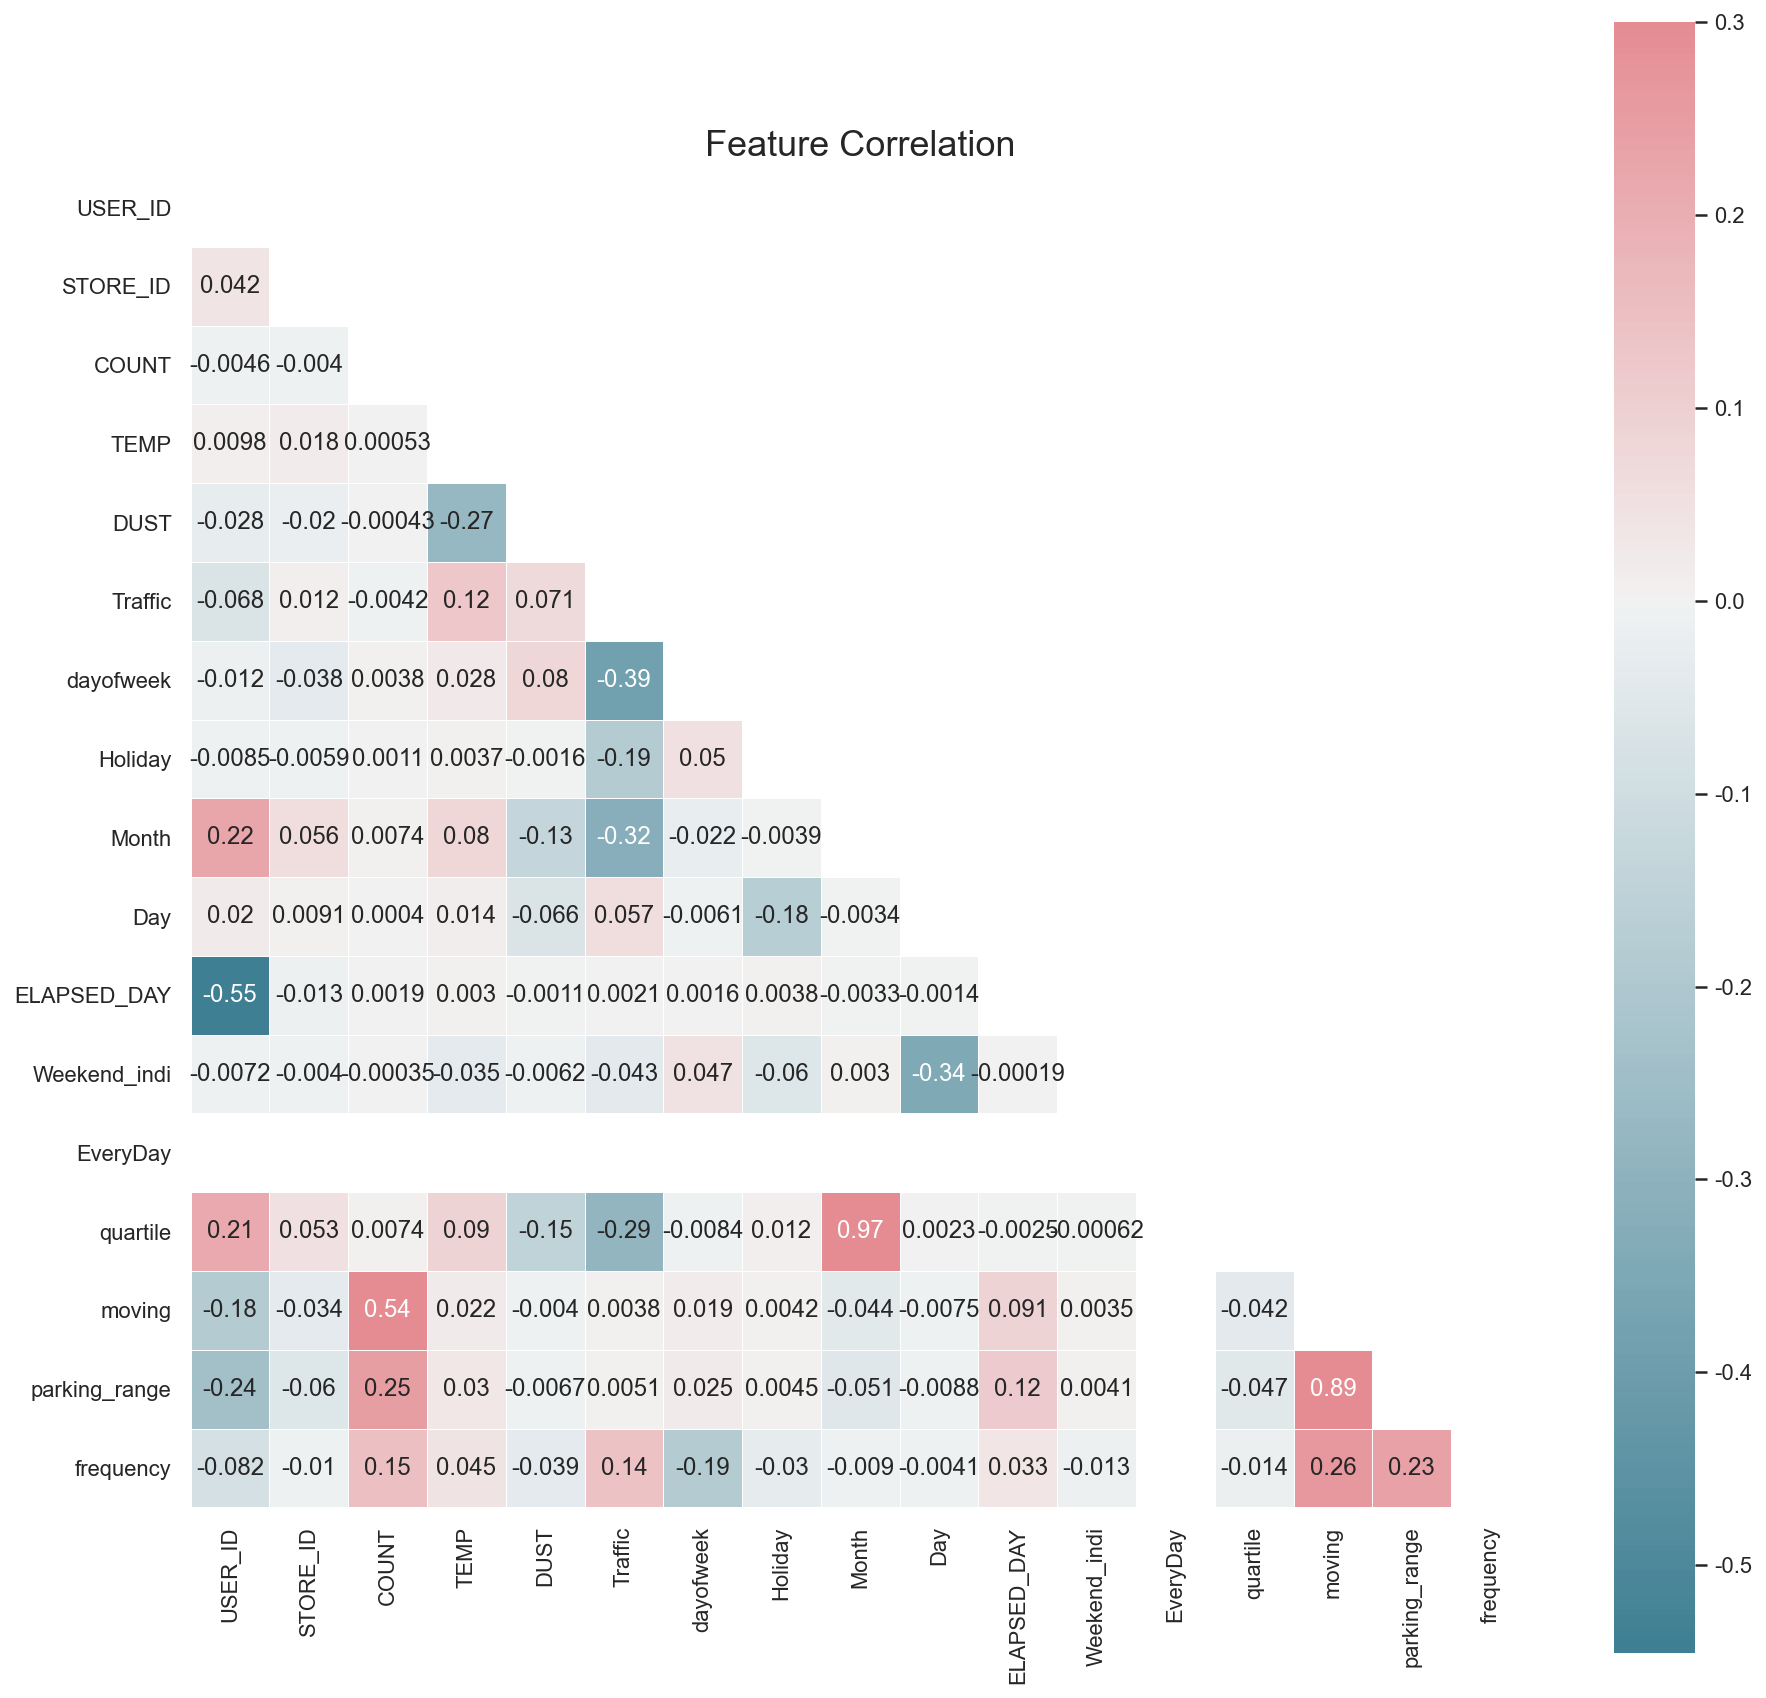

In [31]:
ndata=ndata.rename(columns={'합계':'Traffic'})
sns.set(style="white")
corr = ndata.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Feature Correlation', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

# Modeling  

## Train, Test set 분리  & Scaling & Labeling 

In [32]:
# 날짜로 자르기 위해 'DATE'를 인덱스로 설정
temp = ndata.copy()
temp.set_index('DATE',inplace=True)
# 데이터 분리
train = temp.loc[:'2020-09-30']
test = temp.loc['2020-10-01':]

# 인덱스 리셋 후 'DATE' 컬럼 삭제
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)


In [33]:
# MinMaxScaling
# temp2[['합계']] = MinMaxScaler().fit(temp2[['합계']]).transform(temp2[['합계']])

# Label Encoding 
cat_cols=['D_TYPE', 'GOODS_TYPE', 'AD1', 'parking_area', 'parking_range']
lbl = LabelEncoder()

for col in tqdm(cat_cols):
    temp_df=pd.concat([train, test])
    lbl.fit(temp_df[col]) 
    train[col]=lbl.transform(train[col])
    test[col]=lbl.transform(test[col])    

  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
drop_cols=['USER_ID', 'Day', 'Holiday','JOIN_DATE', 'STORE_ID', 'quartile', 'DoW', 'COUNT', 'EveryDay']
train_X = train.drop(drop_cols,1)
train_y = train[['COUNT']]

test_X = test.drop(drop_cols,1)
test_y = test[['COUNT']]

## Training     
### Score Boards   
|Set|encoding|model|avg val MSE/MAE|test MSE/MAE|Kfolds| 
|---|-----|---------|-----------|--------|------|
|Basic Set (D_TYPE, GOODS_TYPE, AD1, Month, Day)|label| RF|0.14/0.04|0.32/0.05|O
|Basic Set|label|LGBM|0.13/0.04|0.37/0.05|O
|+dayofweek|label| RF|0.09/0.04| 0.34/0.05|O
|+dayofweek, holiday, weekend_indi(=(1))|label| RF|0.09/0.04| 0.34/0.05|O
|+ELAPSED_DAY|label, dum|LGBM|0.038/0.039|0.17/0.05|O
|+ELAPSED_WEEK|label, dum|LGBM|0.037/0.039|0.17/0.05|O
|+JOIN_YEAR|label, dum|LGBM|0.037/0.039|0.106/0.049|O
|+JOIN_DAYS|label|RF|0.046/0.040|0.109/0.048|O
|+AvgTemp|label|RF|0.14/-|0.33/0.05|O
|+AvgTemp|label|LGBM|0.14/-|0.42/0.05|O
|+AvgTemp,Rain,Snow|label, dum|RF|0.14/0.04|0.32/0.05|O
|+AvgTemp,dust(=(2))|label|LGBM|0.14/0.04|0.41/0.05|O
|+dust|label|LGBM|0.14/0.04|0.39/0.05|O
|+(1),(2),traffic,moving,parking_area,parking_range|label, dum(dust)|LGBM|0.03/0.03 |0.09/0.04|Kfold[0]|
|+(1),(2),traffic,moving,parking_area,parking_range,frequency| label, dum(dust)|LGBM|0.03/0.03 |0.09/0.04|X|
|Final|label|LGBM| - |0.089/0.043|X
|Final|label|RF| - |0.078/0.066|X



### 교차 검증 적용 
- 결론적으로 교차 검증 적용이 교차 검증을 하지 않을 때 보다 더 높은 MAE, MSE를 보여줌  
- 이는 데이터셋 특성상 이용횟수가 매우 큰 outliers의 분포가 테스트셋과 트레인셋에서 다르게 나타나 교차검증시 사용된 outliers가 학습되지 못했기 때문일 것이라 추정.  
- 따라서 최종 모델은 교차 검증을 하지 않고 훈련하기로 함 

In [35]:
# cv_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
# cv = KFold(n_splits=5, shuffle=True, random_state=11)

In [36]:
# # ============================ Final model(1) : LGBM

# lg_mse=[]
# lg_mae=[]

# lg_models={}

# X=train_X
# y=train_y

# for i , (trn_idx, val_idx) in tqdm(enumerate(cv_s.split(X=X, y=y))):
#     trn_data, trn_label = X.iloc[trn_idx], y.iloc[trn_idx]
#     val_data, val_label = X.iloc[val_idx], y.iloc[val_idx]

#     print(f'========== {i} Fold ==========')
    
#     print(f'TRAINING LGBM Regressor')
#     lg_model=lgbm.LGBMRegressor(**hyper_params)
    
#     lg_model.fit(trn_data, trn_label,
#         eval_set=[(val_data, val_label)],
#         eval_metric='l1',
#         early_stopping_rounds=500)

#     lg_trn_pred = lg_model.predict(trn_data, num_iteration=lg_model.best_iteration_)
#     lg_trn_mse = mean_squared_error(lg_trn_pred, trn_label)
#     lg_trn_mae = mean_absolute_error(lg_trn_pred, trn_label)
    
#     lg_val_pred = lg_model.predict(val_data, num_iteration=lg_model.best_iteration_)
#     lg_val_mse = mean_squared_error(lg_val_pred, val_label)
#     lg_val_mae = mean_absolute_error(lg_val_pred, val_label)
    
#     print(f'train mse : {lg_trn_mse}, train mae : {lg_trn_mae}')
#     print(f'val mse : {lg_val_mse}, , val mae : {lg_val_mae}')
#     print()
    
#     lg_mse.append(lg_val_mse)
#     lg_mae.append(lg_val_mae)
#     lg_models[i]=lg_model

# print(f'Average mse of Val Set : {np.mean(lg_mse)}')
# print(f'Average mae of Val Set : {np.mean(lg_mae)}')


# #test 
# lg_test_pred = lg_model.predict(test_X, num_iteration=lg_model.best_iteration_)
# lg_test_mse = mean_squared_error(lg_test_pred, text_y)
# lg_test_mae = mean_absolute_error(lg_test_pred, test_y)

# print(f'MSE of Test set : {lg_test_mse}')
# print(f'MAE of Test set : {lg_test_mae}')  

### 교차검증 미적용 

In [37]:
#------------------- Final Model (1) light gbm
hyper_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.001, 
    "n_estimators": 600,
}

lgbr = lgbm.LGBMRegressor(n_estimators=100,
                         max_bin=2000) 
lgbr.fit(train_X, train_y)
y_pred2 = lgbr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred2)
MAE = mean_absolute_error(test_y, y_pred2)
print('MSE :', MSE)
print('MAE :', MAE)

MSE : 0.08867030526284166
MAE : 0.04392860282180636


In [38]:
#------------------- Final Model (2) Random Forest
rf = RandomForestRegressor()
rf.fit(train_X, train_y)

y_pred1 = rf.predict(test_X)

MSE = mean_squared_error(test_y, y_pred1)
MAE = mean_absolute_error(test_y, y_pred1)
print('MSE :', MSE)
print('MAE :', MAE)

MSE : 0.07930299639777953
MAE : 0.0673566578898892


In [39]:
# ------ Grid Search : 시도했으나 너무 시간이 오래걸림. 
# from sklearn.model_selection import GridSearchCV
# param_grid = {}
# param_grid['n_estimators'] = [400, 700, 1000]
# param_grid['max_depth'] = [5, 10, 15, 20]
# param_grid['min_samples_split'] = [100, 400, 700, 1000]
# grid_model = GridSearchCV(rf,
#                           param_grid=param_grid,
#                           n_jobs=-1)

# grid_model.fit(train_X, train_y)

# print(f'best_params : \n{grid_model.best_params_}')
# print(f'best_model : \n{grid_model.best_estimator_}')

# rf_y_pred = grid_model.predict(test_X)
# MSE = mean_squared_error(test_y, y_pred1)
# MAE = mean_absolute_error(test_y, y_pred1)
# print('TEST SET MSE :', MSE)
# print('TEST SET MAE :', MAE)

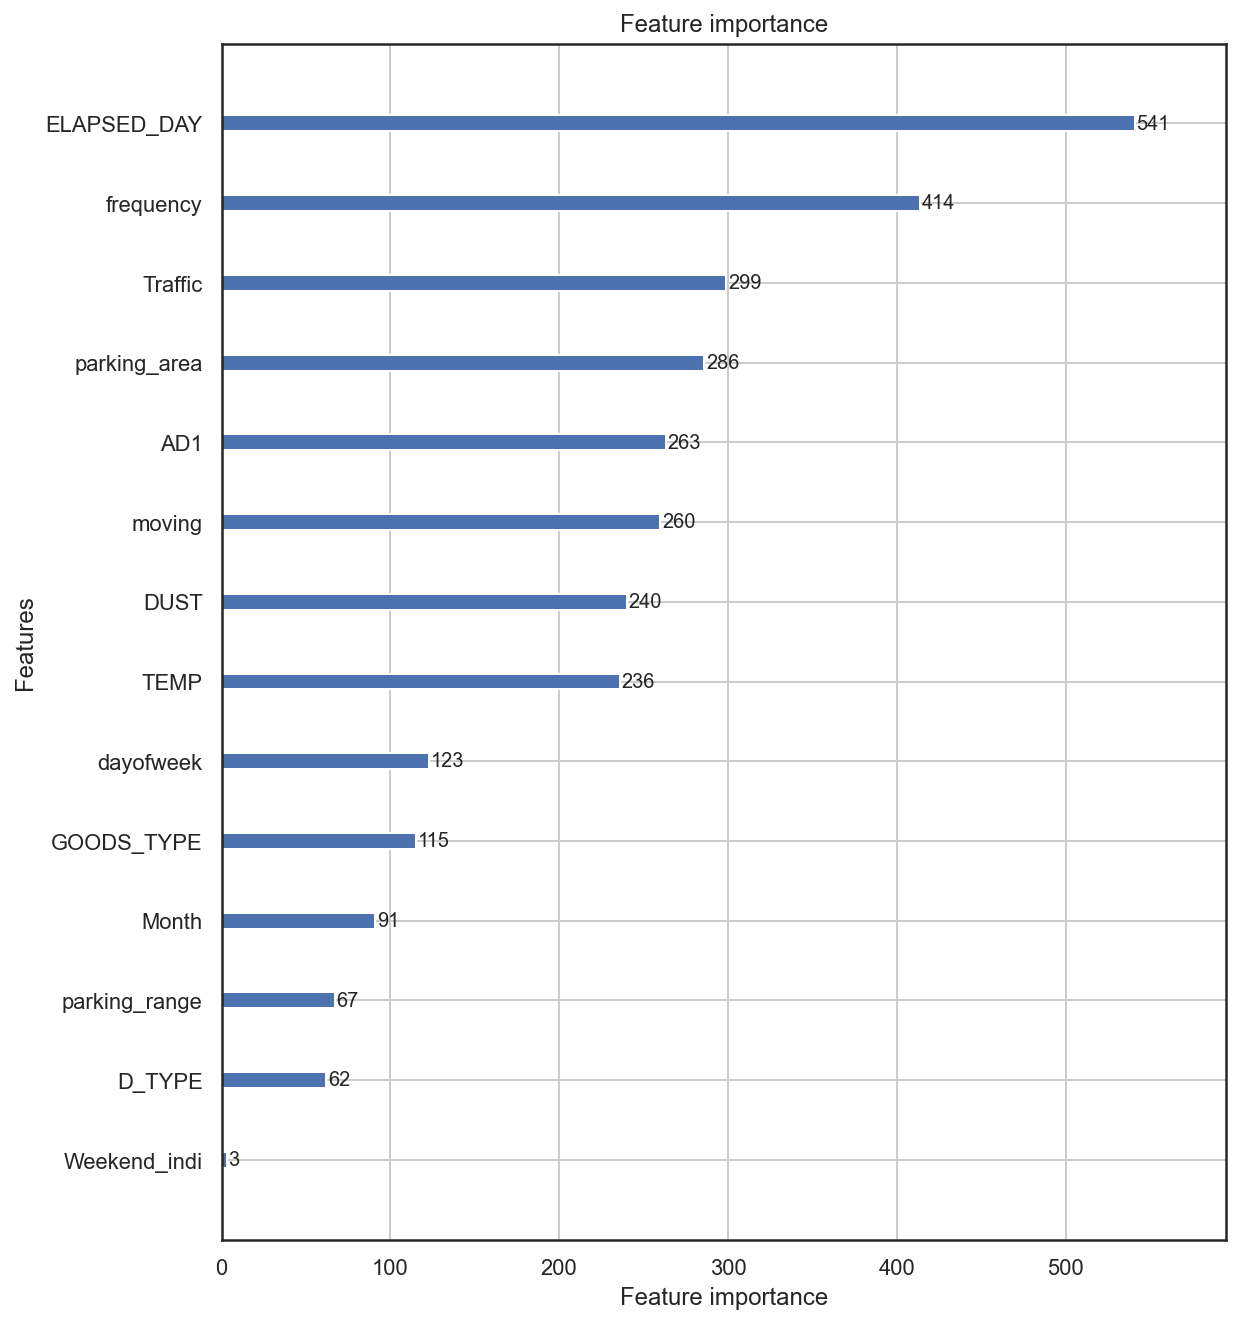

In [42]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,11))
plot_importance(lgbr, ax=ax)
plt.savefig('변수의 중요도.png')

# Modeling Results

In [40]:
final_result = pd.DataFrame({'pred_LGBM': y_pred2, 'pred_RF':y_pred1,
                          'actual value' : test_y.values.ravel()})

In [41]:
final_result.head()

pred_LGBM  pred_RF  actual value
0          1        1             1
1          1        1             1
2          1        1             1
3          1        1             1
4          1        1             1